<a href="https://colab.research.google.com/github/DanilSavine/Dojo_DeepLearning/blob/main/DanilSavine_Visualization_TB2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on visualization of Neural Networks

This exercise aims at exploring different ways of visualizing Neural Networks:
- t-SNE of representations (CIFAR10)
- grad-CAM (ImageNet)
- activation maximization (ImageNet)

First, some preliminaries that facilitate plotting and data access on Google drive ... just execute !

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%load_ext autoreload
%autoreload 2

import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive')

#%cd /content/gdrive/My\ Drive/Colab\ Notebooks/dlia_course/practical_sessions/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# basic imports
import os
import time

# import keras and tensorflow classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# check the hardware settings
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# use GPU as hardware acceleration.
tf.device('/device:GPU:0')

# Visualization of the encodings by t-SNE

First, we will visualize encodings of a network trained on the CIFAR data set. Here, we import and preprocess the data. We keep the original labels in `y_data` (to be used for visualization later on). For training, we need to transform them to one-hot-vectors.

In [3]:
from tensorflow.keras.datasets import cifar10

(x_data, y_data), (x_test, y_test) = cifar10.load_data()


**Assignment**: To use as input to our classification model, we need to preprocess the data:


*   Convert x to float and normalize values to [0, 1]
*   Convert y to one-hot vectors, using to_categorical from tensorflow.keras.utils
* Split train/val data by taking first 40000 images for training and the rest for validation



In [4]:
def normalization(x):
  x = x.astype('float32')
  x /= 255.0
  return x

# preprocessing (normalization)
x_data_processed = normalization(x_data)
x_test_processed = normalization(x_test)

# encodings in one-hot-vectors
y_train_cat = tf.keras.utils.to_categorical(y_data)
y_test_cat = tf.keras.utils.to_categorical(y_test)

# train/val separation
train_size = 40000
x_train = x_data_processed[:train_size]
x_val = x_data_processed[train_size:]
y_train = y_train_cat[:train_size]
y_val = y_train_cat[train_size:]

We will first visualize the data.

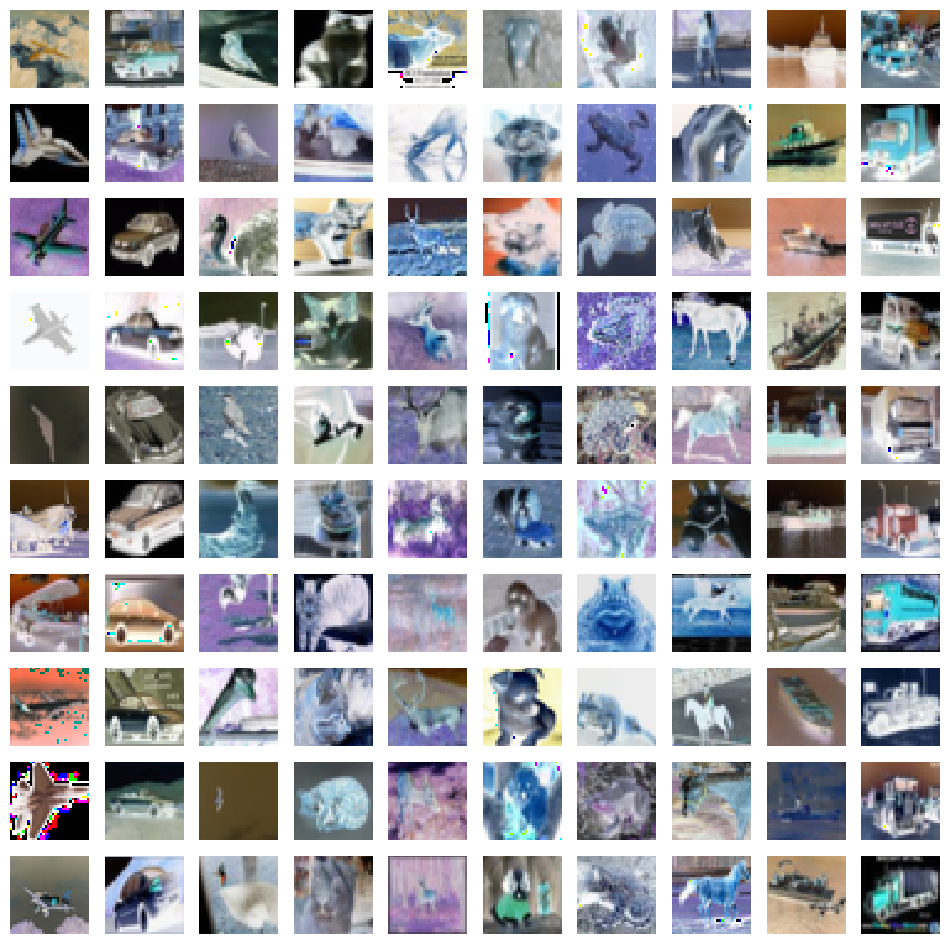

In [5]:

# helper function to plot a few images for each class
def plot_array(fig, X, Y, classes_to_plot=None, samples_per_class=7):
    if classes_to_plot is None:
        classes_to_plot = np.unique(Y)
    num_classes = len(classes_to_plot)

    for k, y in enumerate(classes_to_plot):
        idxs = np.flatnonzero(Y == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        #print(y, idxs)

        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + k + 1
            ax = fig.add_subplot(samples_per_class, num_classes, plt_idx)
            ax.imshow(X[idx].astype(np.uint8))
            ax.axis('off')
fig = plt.figure(figsize=(12, 12))
plot_array(fig, x_data*255, y_data, samples_per_class=10)

Next we define a neural network and train it on the data set. We output the model summary. The model summary gives you also the names of each of the layers.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])




Now, we train the neural network, we observe training and validation error, and we try to get a solution that roughly obtains 75\% or more on the test set.

In [7]:
# model fit
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_data=(x_val, y_val))

model.evaluate(x=x_test, y=y_test_cat)

Epoch 1/10
625/625 [==============================] - 12s 12ms/step - loss: 1.7346 - accuracy: 0.3689 - val_loss: 1.3232 - val_accuracy: 0.5305
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 1.2479 - accuracy: 0.5558 - val_loss: 1.0691 - val_accuracy: 0.6234
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 1.0311 - accuracy: 0.6378 - val_loss: 0.9192 - val_accuracy: 0.6826
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.9061 - accuracy: 0.6858 - val_loss: 0.8300 - val_accuracy: 0.7097
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.8175 - accuracy: 0.7151 - val_loss: 0.7369 - val_accuracy: 0.7431
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.7587 - accuracy: 0.7363 - val_loss: 0.7940 - val_accuracy: 0.7311
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.7085 - accuracy: 0.7555 - val_loss: 0.7482 - val_accuracy: 0.7567


[146.68731689453125, 0.5692999958992004]

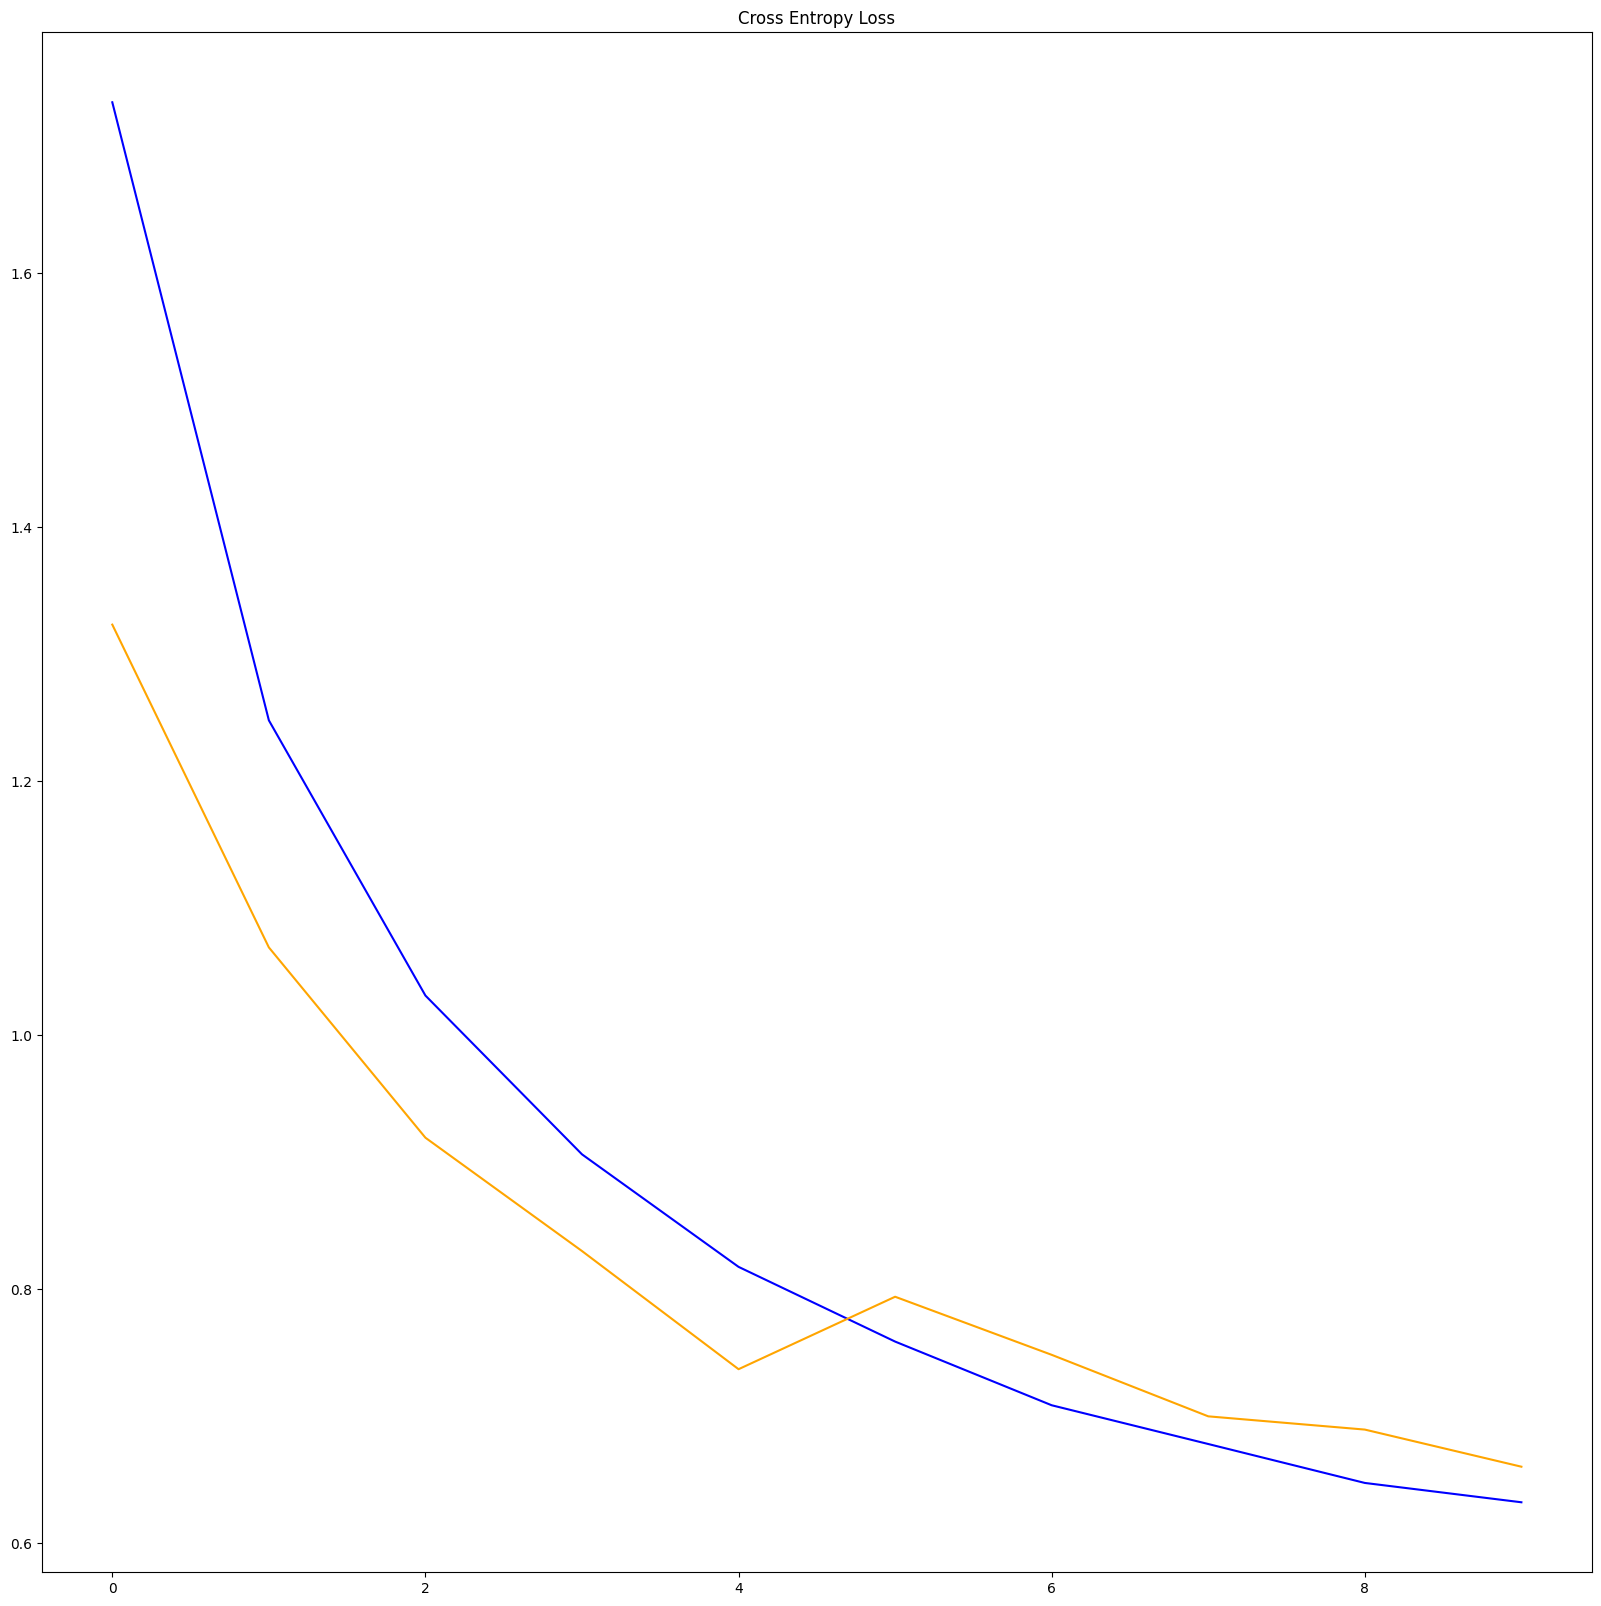

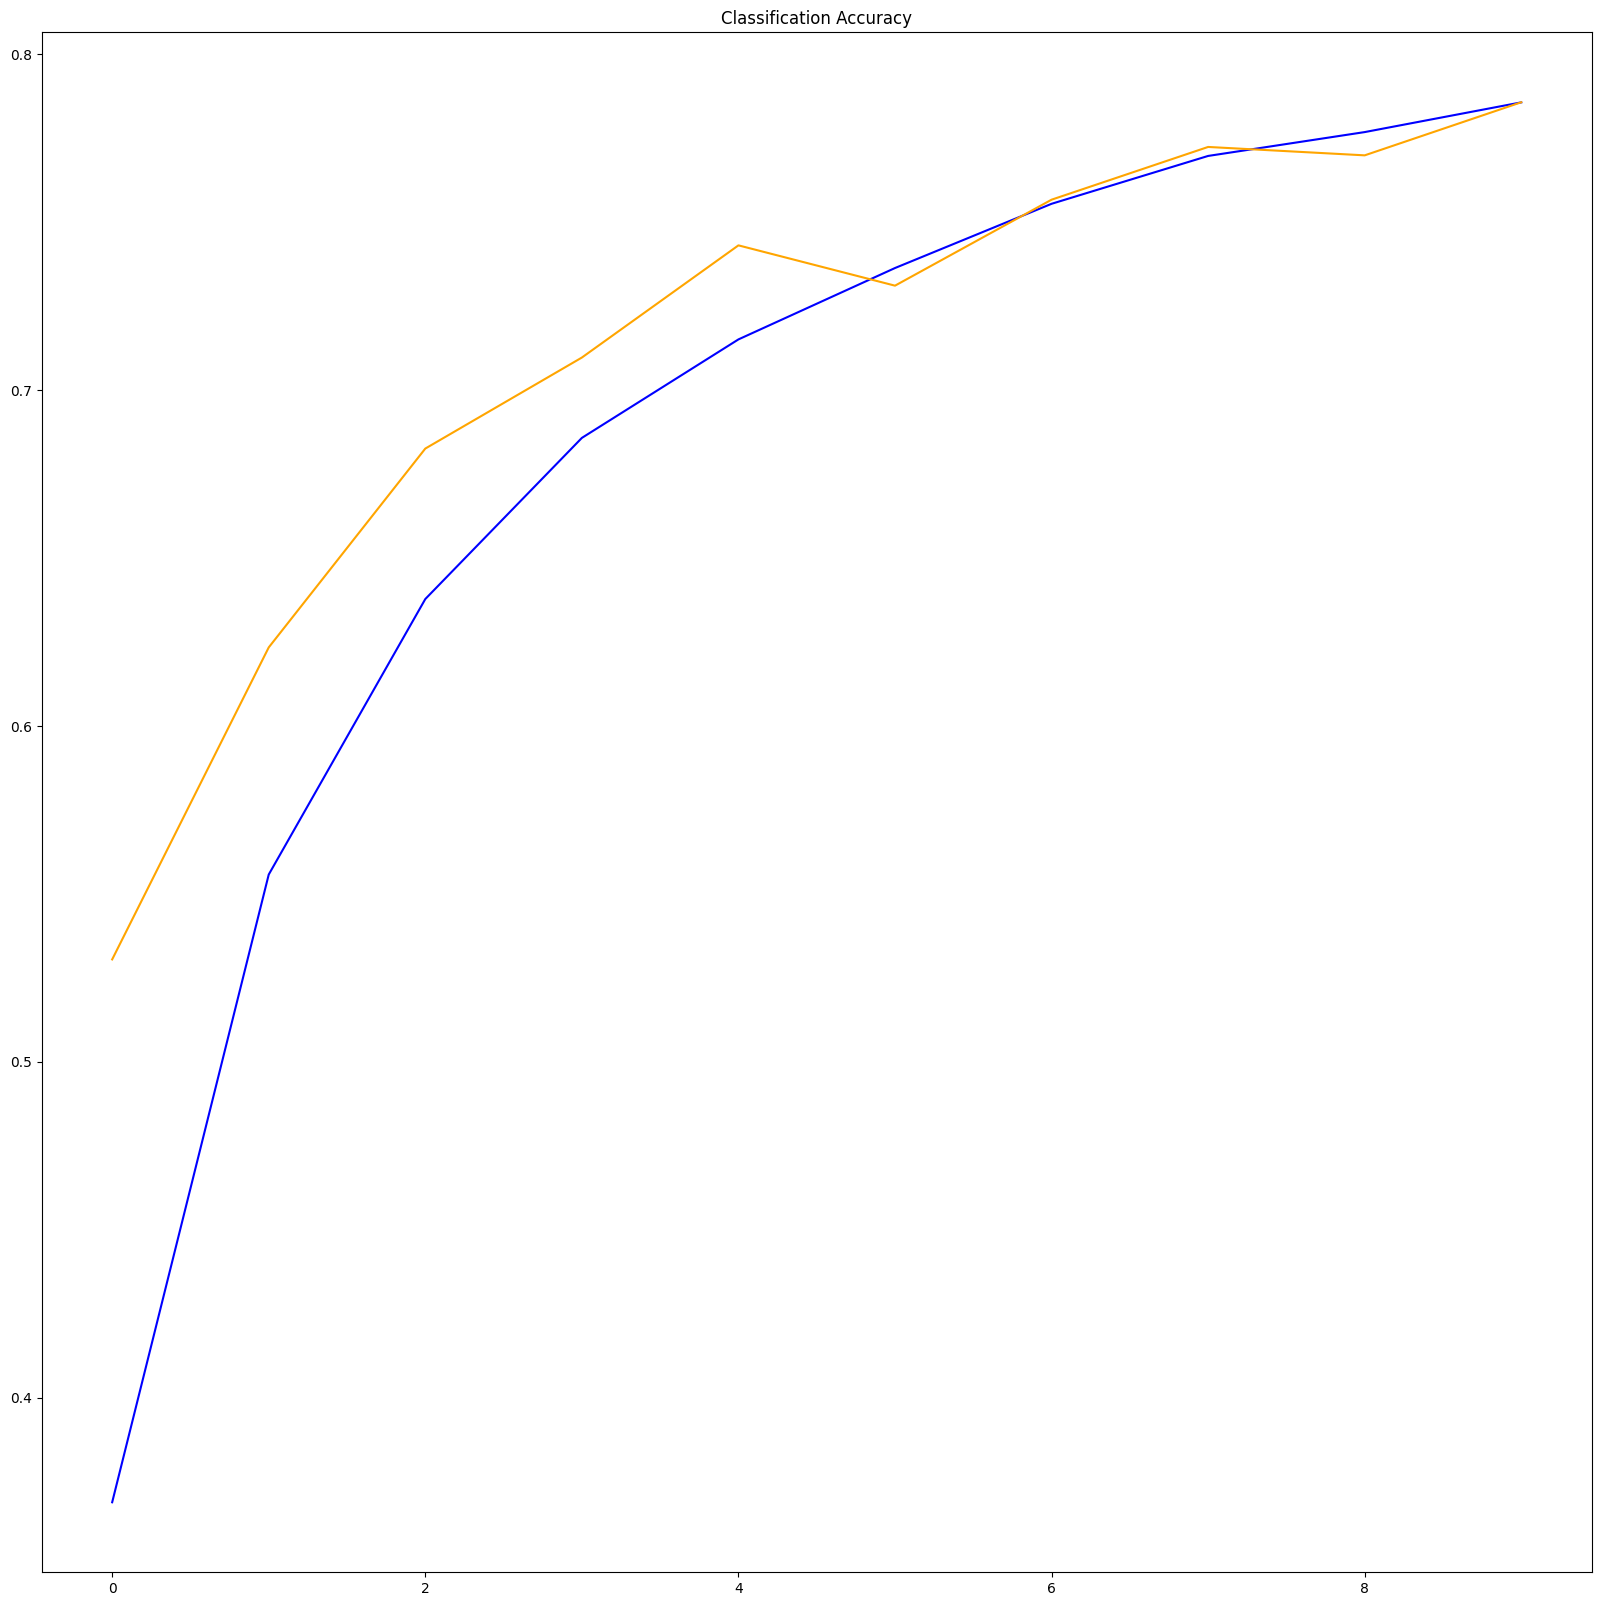

In [8]:
# We plot the learning curves (loss and accuracy)

# plot loss
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history['val_loss'], color='orange', label='validation loss')
plt.show()

# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='training acc')
plt.plot(history.history['val_accuracy'], color='orange', label='validation acc')
plt.show()


Now, we need to define a few plots ... just execute !

In [9]:
class_definition = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
                    4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship',
                    9: 'truck'}

from matplotlib.colors import to_hex

# definition of the scatterplot
def make_scatterplot(X, y, feature1=None, feature2=None,
                     class_indices=None, class_definition=None):
    if class_indices is None:
        class_indices = np.unique(y)
    if class_definition is None:
        class_definition = dict(zip(class_indices, [str(i) for i in class_indices]))
    if feature1 is None:
      feature1 = 'Component 1'
    if feature2 is None:
      feature2 = 'Component 2'

    # colors
    colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title('Scatter plot: %s vs. %s' % (feature2, feature1))

    comp1 = X[:,0]
    comp2 = X[:,1]
    for class_index in class_indices:
        class_label = class_definition[class_index]
        ax.scatter(comp1[y==class_index],
                   comp2[y==class_index],
                   c=to_hex(colors[class_index]),
                   label=class_label,
                   s=15)
    ax.legend()
    ax.grid()

Now, we will extract the features of a layer and visualize the distribution of the encodings with t-SNE.

First, we start with layer `flatten`. This is the last layer before the dense layers in the network.

In [10]:

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [11]:
from tensorflow.keras.models import Model

# we limit ourselves to 1000 training samples. t-SNE does not scale
# very well with the number of samples.
x = x_data[:1000]
y = y_data[:1000]

layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features = intermediate_layer_model.predict(x)

print(features.shape)

32/32 [==============================] - 1s 17ms/step
(1000, 2048)


Finally, we perform t-SNE.

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


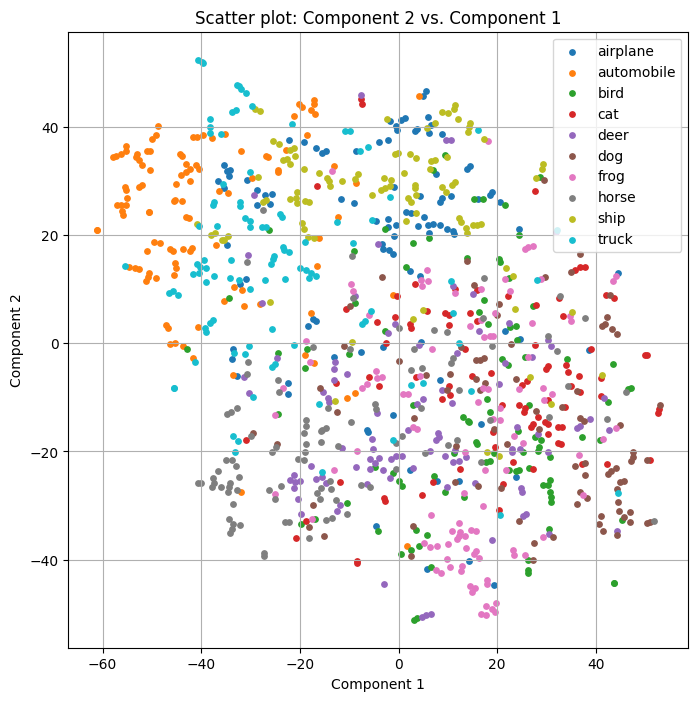

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

**Assignment**: Explain what is a feature vector (hint: other terms in the literature are "Encodings", "Embeddings")

**Answer**: A feature vector is a representation of data in a lower-dimmension space. We could access such a representation by looking at the outputs of one of the hidden layers.

**Assignment**: Try out several perplexities: 5, 10, 30. What do you observe?

**Answer** For low perplexity we get very dense small clusters. When we increase perplexity, we see that we get  clusters with larger number of points. Starting from 10 we start to distinguish intresting regions where the classes seem to occupy the same space. This might indicate that the network learnt to distinguish them.

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


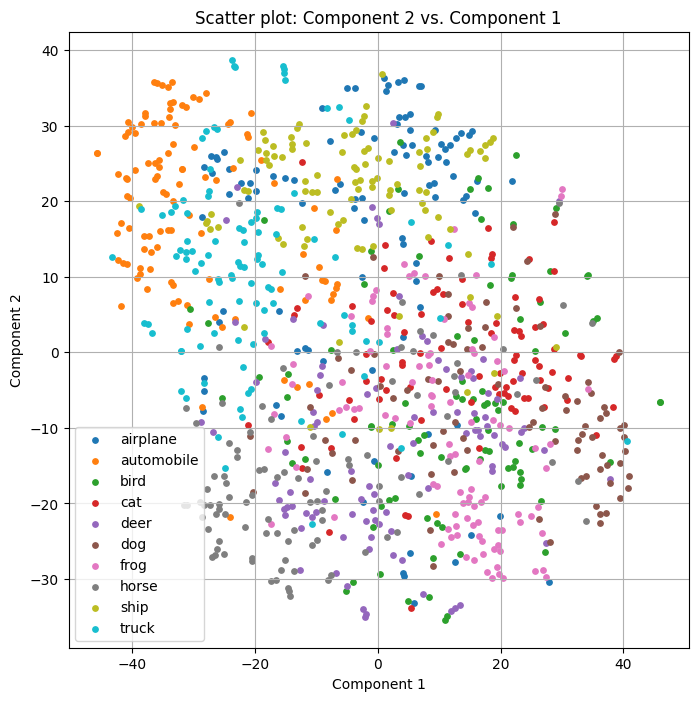

In [13]:

X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


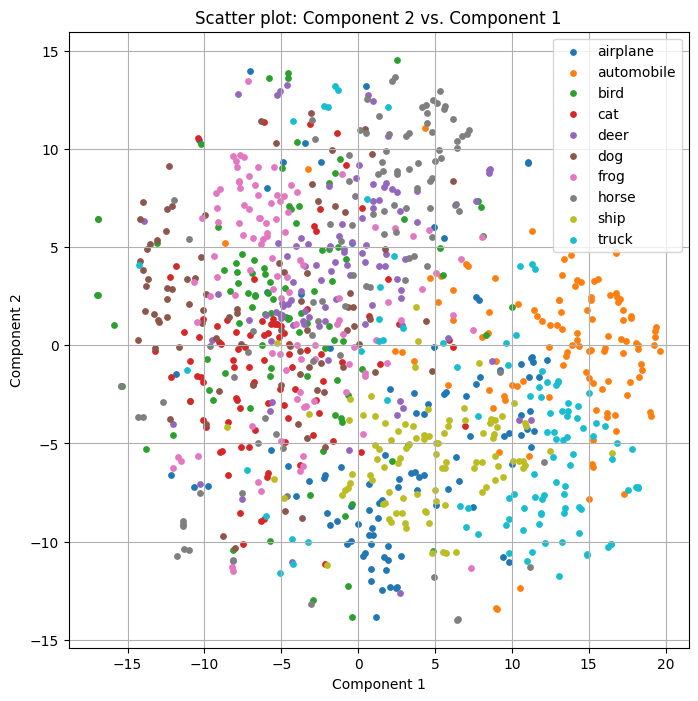

In [14]:

X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

**Assignment**: Visualize now the scores at the two fully connected layers. Why are the representations so strikingly different? Imagine you would like to use the same representations in another project (same image size, but other classes). Which of the representations seems less useful? Why?


**Answer** The very last fully connected layer output is of dimmension 10, meaning that we already get the scores of our classification as output of this layer. We see that indeed we have very clear clusters. This representation would not be useful.

On the constrary, the penultimate fully connected layer's output is of dimmension 1000, and while we start to see regions of space associated to certain classes, the output seems like it could be easily fine-tuned to other classes.

In [15]:
def visualize_tSNE(layer_name, perplexity):
  intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
  features = intermediate_layer_model.predict(x)

  X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(features)
  make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)
  print(features.shape)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

32/32 [==============================] - 0s 2ms/step


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


(1000, 128)


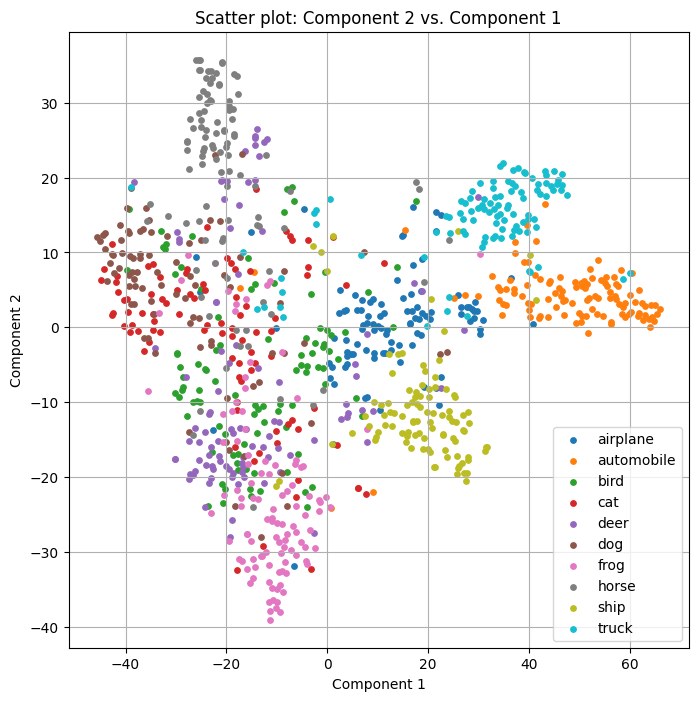

In [17]:
visualize_tSNE("dense", 20)

32/32 [==============================] - 0s 2ms/step


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


(1000, 10)


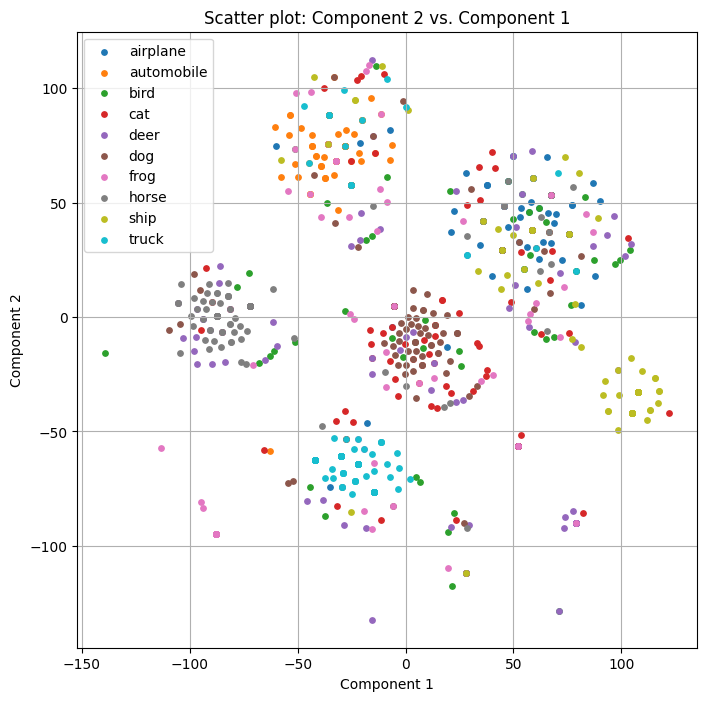

In [18]:
visualize_tSNE("dense_1", 20)

**Assignment**: Visualize the tSNE plot of the model before training, what do
you observe? (flatten layer and last fully_connected layer)

**Answer**: In the case of the model before training we see the embeddings with the initialized weights of the network. It looks more like random noise, and less useful. Which makes of course sense as the network has not yet been trained.

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

32/32 [==============================] - 0s 2ms/step


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


(1000, 2048)


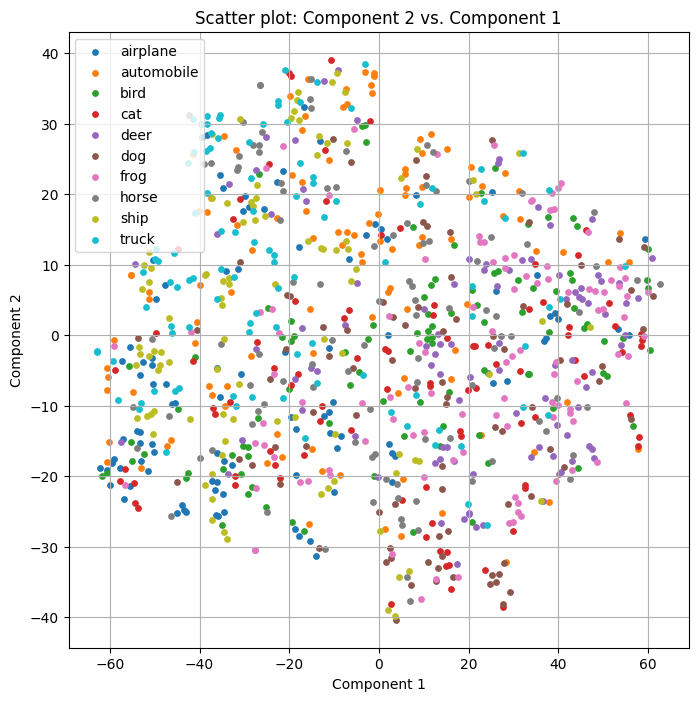

In [20]:
visualize_tSNE("flatten_1", 10)

32/32 [==============================] - 0s 2ms/step


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


(1000, 10)


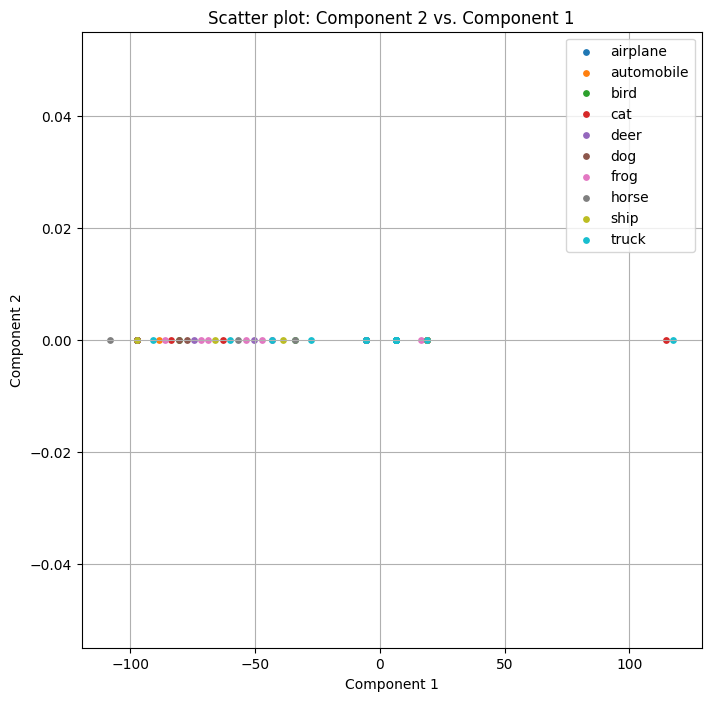

In [21]:
visualize_tSNE("dense_3", 10)

# Classification activation maps (grad-CAM)

Classification activation maps provide certainly the most popular visualization methods for network inspection.

In [52]:
!pip install --upgrade tf-keras-vis

In [53]:
from tf_keras_vis.gradcam import Gradcam

Next, we will load VGG16, pretrained on `ImageNet`. This is the network we are going to investigate.

In [68]:
# Pretrained network: VGG16
from tensorflow.keras.applications import VGG16

# We want to extract the entire network, including the finaly layer.
model = VGG16(weights='imagenet',include_top=True)

# We show the summary of model (to recall the dimensions)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now, we load an image from the `ImageNet` data base. We have downloaded these images: they are in the folder `imagenet`.

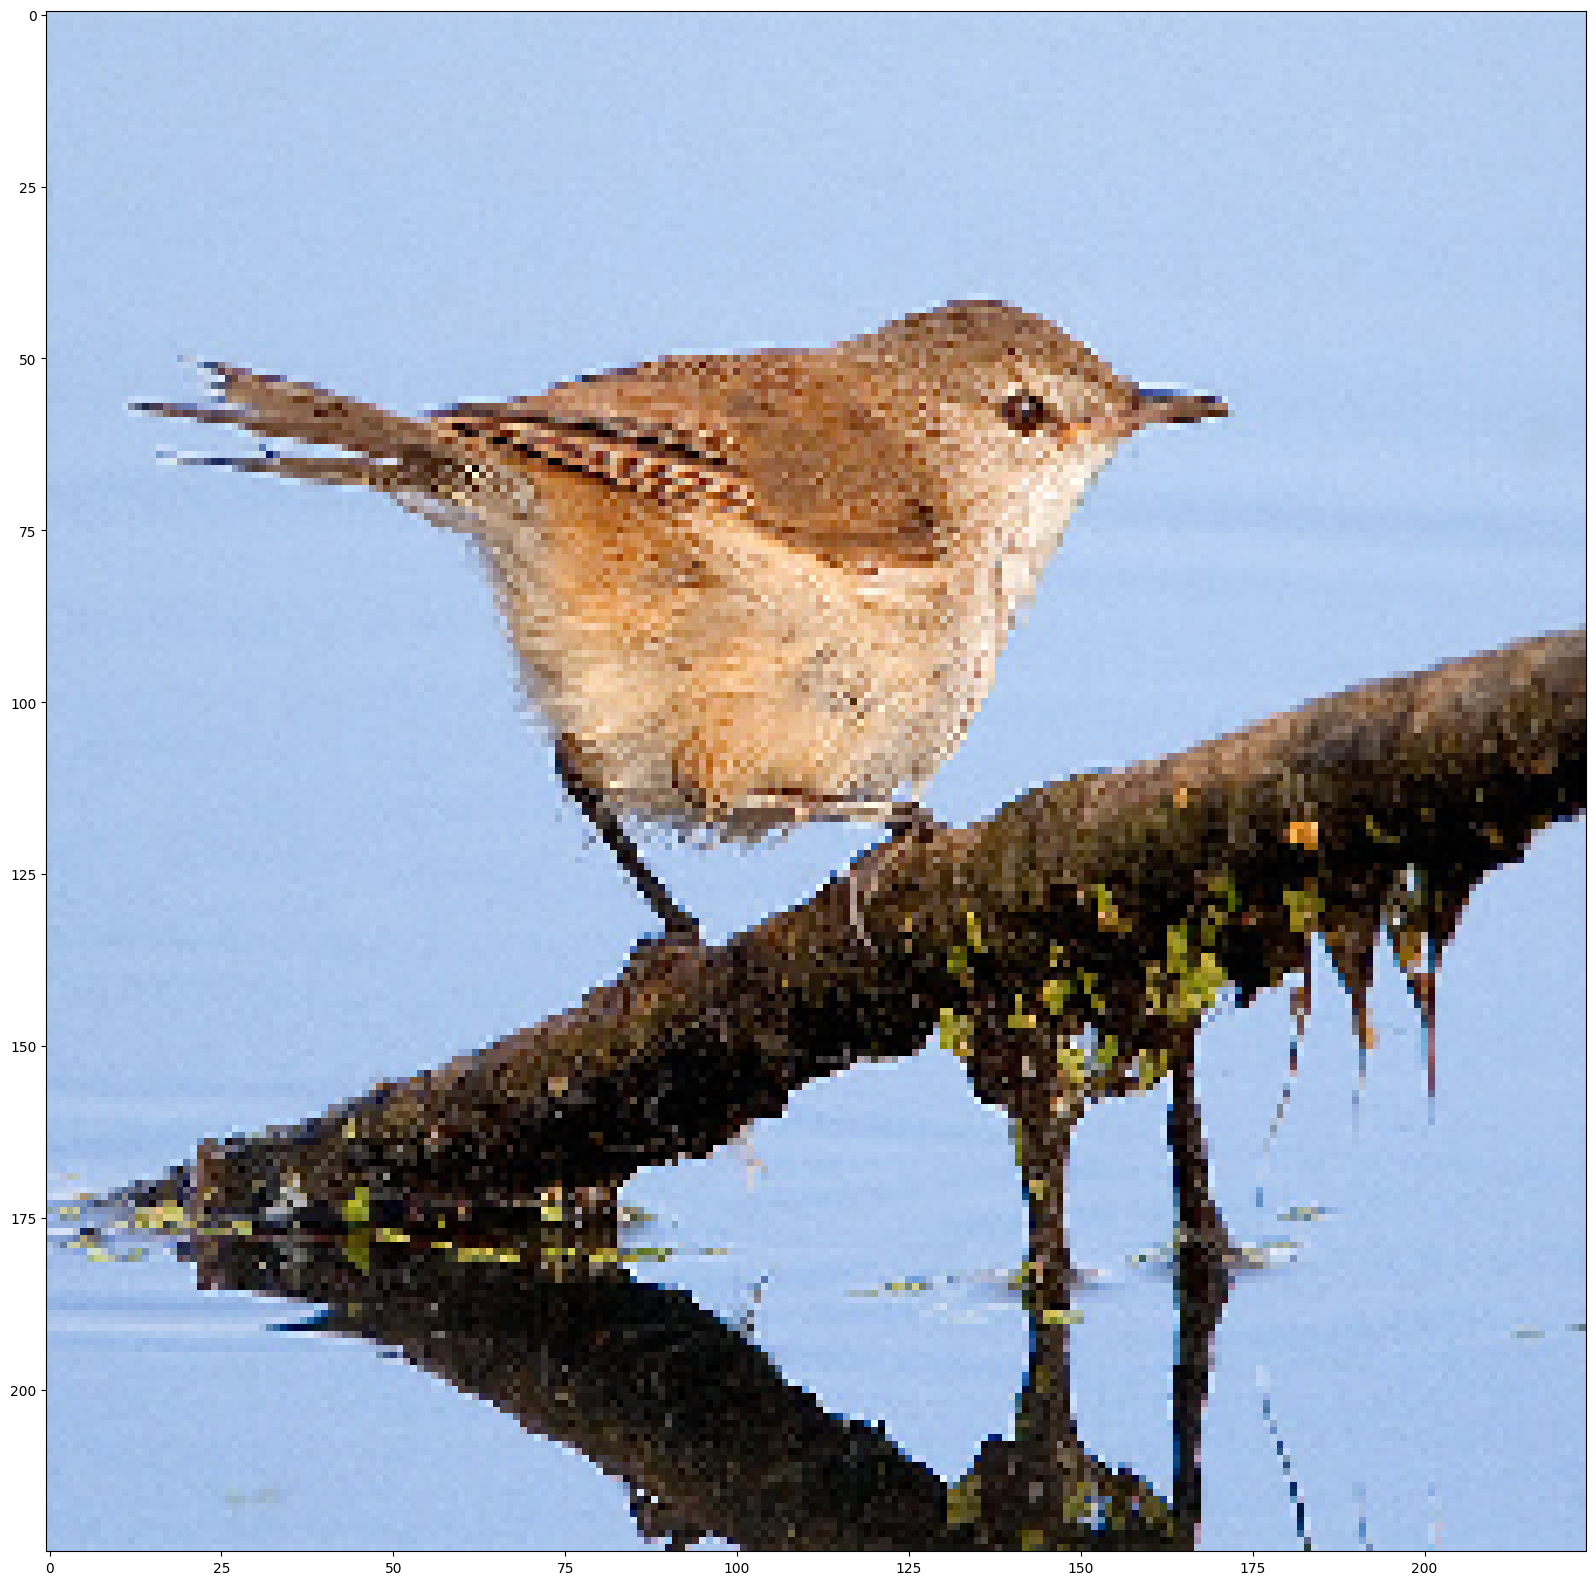

In [55]:
import os
filename = '418657219_3567961db1.jpg'

# animals:
# bird : filename = '418657219_3567961db1.jpg'
# dog : filename = '425248370_b15374000e.jpg'
# bird : filename = '485627874_8f4144223a.jpg'

# bridges:
# filename = 'bridge1.jpg'
# filename = 'bridge2.jpg'
# filename = 'bridge3.jpg'

folder_name = '/content/gdrive/MyDrive/Colab Notebooks/DATA/ImageNet'
# folder_name = '/content/gdrive/MyDrive/01_PROJECTS/practical_sessions/imagenet'
# folder_name = '/content/gdrive/My Drive/Colab Notebooks/dlia_course/practical_sessions/imagenet'
from tensorflow.keras.preprocessing.image import load_img
image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))
plt.imshow(image)


Now, we will predict the label of the image.

In [56]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# convert the image pixels to a numpy array
img_prep = img_to_array(image)

# reshape data (the model expects a batch of images.)
img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

# prepare the image for the VGG model
img_prep = preprocess_input(img_prep)

# predict the probability across all output classes
img_prediction = model.predict(img_prep)

# the output is a 1000-dimensional vector of posterior probabilities.
print('Shape of the output vector:', img_prediction.shape)

# result
print('Prediction result:', decode_predictions(img_prediction, top=3))
max_index = np.argmax(img_prediction)
print('Solution Index: ', max_index)

1/1 [==============================] - 0s 254ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n01601694', 'water_ouzel', 0.99239105), ('n02027492', 'red-backed_sandpiper', 0.0048558414), ('n02028035', 'redshank', 0.0018742444)]]
Solution Index:  20


We need to define a few helper functions. First the `model_modifier` that replaces the `softmax` by a linear layer. The reason is that we cannot study the influence of neurons on the output $y_k$, if the output depends on all classes (which is the case when we use `softmax`).

In [57]:
# model modifier
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(img_prediction):
    # the loss gives the score of the image for the correct class.
    # if you want to test the importance for the prediction of another class
    # you have to adapt the index accordingly.
    correct_class_index = np.argmax(img_prediction)
    return img_prediction[0][correct_class_index]

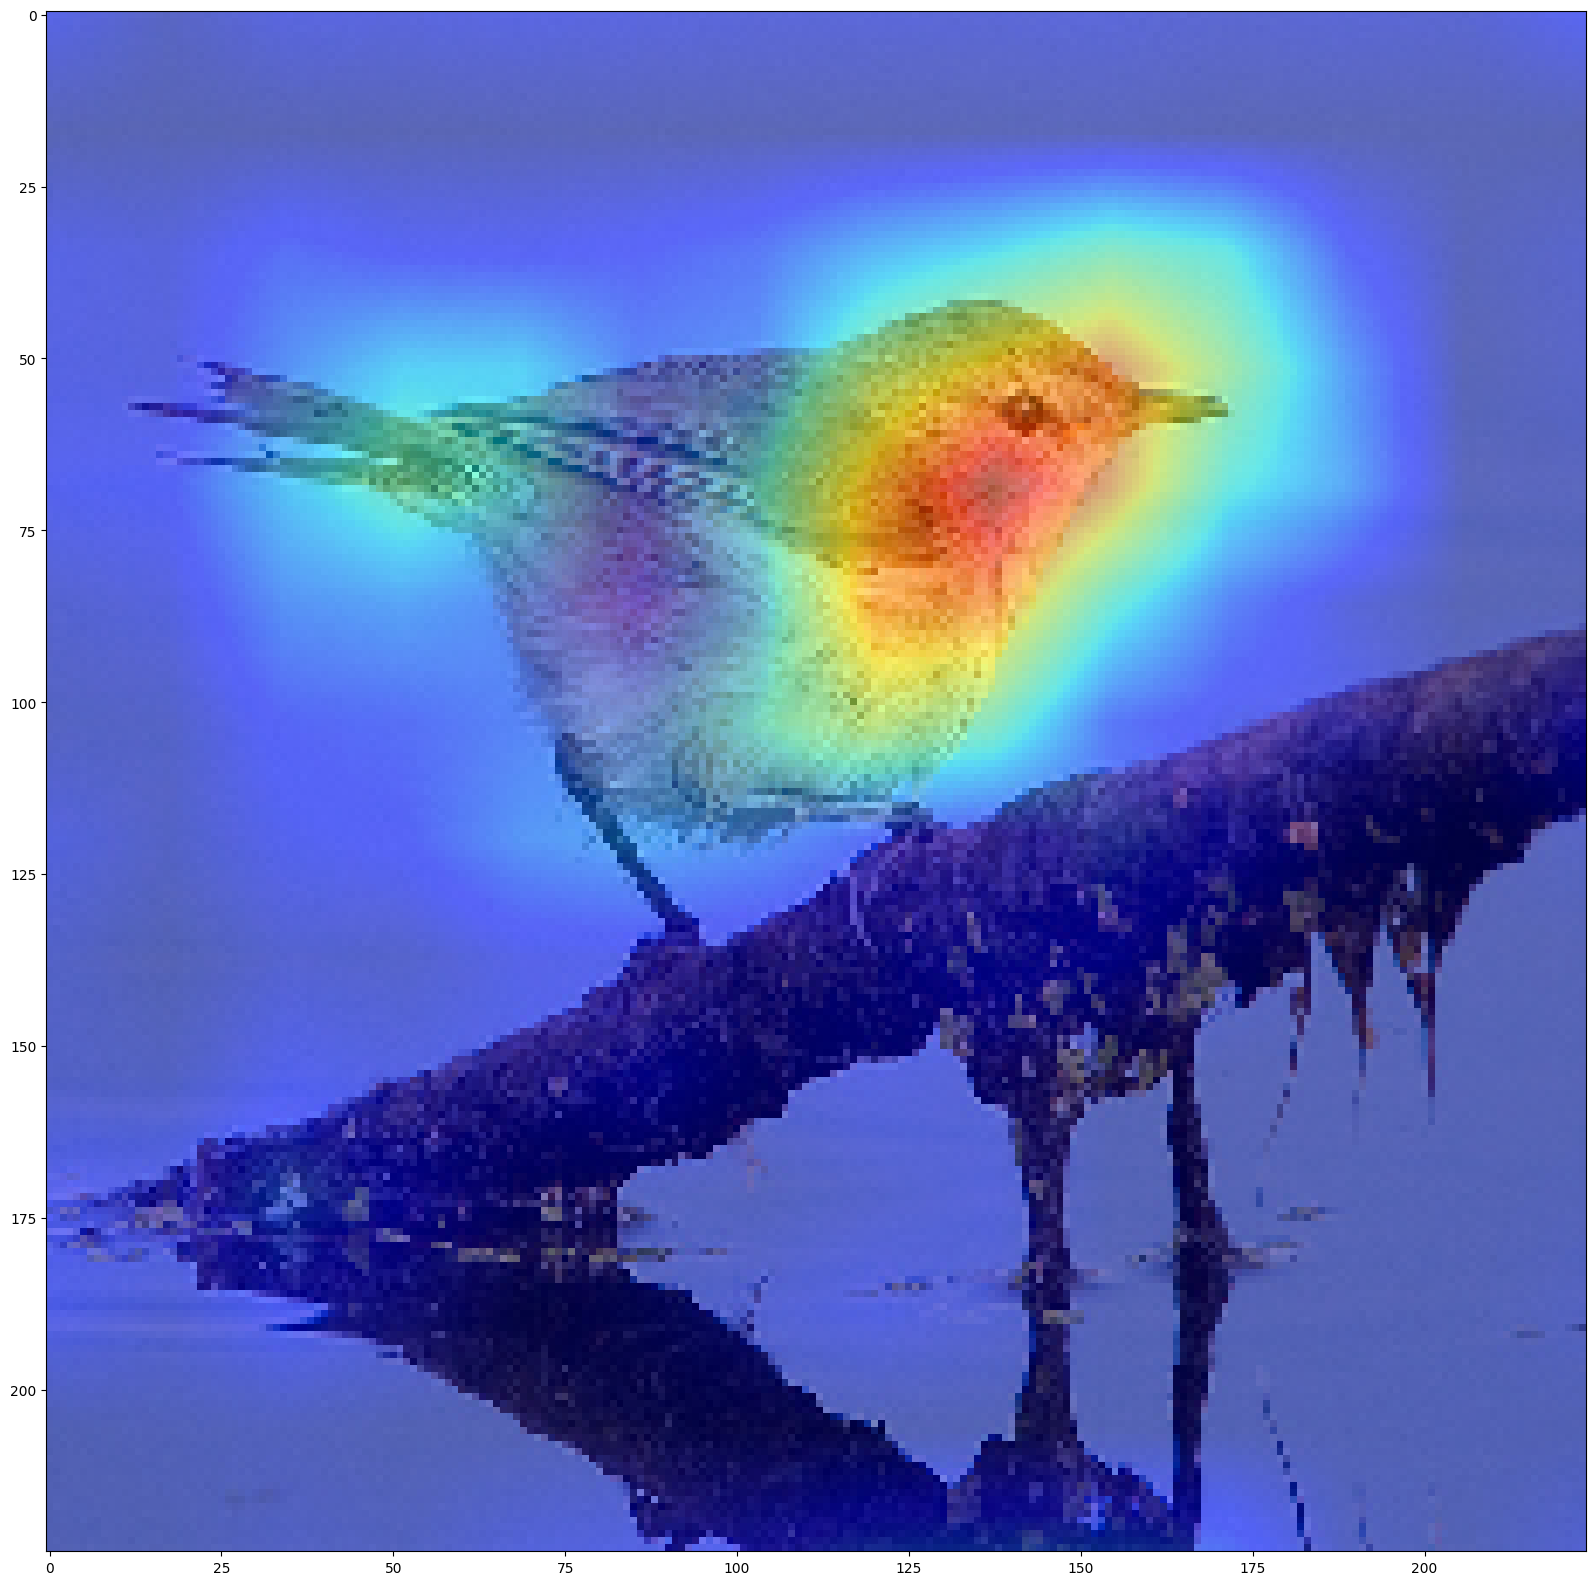

In [58]:
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              img_prep,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

plt.imshow(image)
heatmap = np.uint8(cm.jet(cam[0]) * 255)
plt.imshow(heatmap, cmap='jet', alpha=0.5)


**Assignment:** Test the grad-CAM first on the three animal images, and verify that you obtain a reasonable result. Then test the algorithm on the three bridge images. Visualize the top-3 predictions.(Make a nice plot with the results)

*   For `Bridge1.jpg` you obtain a wrong classification, but what can be said about the learned network in view of the visualization of the top-3 predictions?

**Answer** It looks like the network is not sure, as the entropy is high (top 3 results have similar proabilities). We could also notice that the 2nd result is indeed the stell bridge. The top prediction is a fireboat and the 3rd is a wreck, which migth "make sense" as the Sydney Opera might be mistaken for water jets.

*   For `Bridge3.jpg` you get the right result, but what can you say about the "understanding" of the image in view of your visualization result?

**Answer** In this case suppension bridge has been corretly classified, but the actual "undestanding" seems off as the gradCAM highlights rocks in water rather the bridge itself. The network learnt to find rocks in water rather than the actual bridge.


Note that the correspondence of class names and indices can be found at:
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)


In [59]:
def gradCAM(filename):
  # convert the image pixels to a numpy array

  image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))

  img_prep = img_to_array(image)

  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)

  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)

  # the output is a 1000-dimensional vector of posterior probabilities.
  print('Shape of the output vector:', img_prediction.shape)

  # result
  print('Prediction result:', decode_predictions(img_prediction, top=3))
  max_index = np.argmax(img_prediction)
  print('Solution Index: ', max_index)

  # Create Gradcam object
  gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)

  # Generate heatmap with GradCAM
  cam = gradcam(loss,
                img_prep,
                penultimate_layer=-1, # model.layers number
              )
  cam = normalize(cam)

  plt.imshow(image)
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  plt.imshow(heatmap, cmap='jet', alpha=0.5)

# animals:
# bird : filename = '418657219_3567961db1.jpg'
# dog : filename = '425248370_b15374000e.jpg'
# bird : filename = '485627874_8f4144223a.jpg'

filenames_animals = [
    '418657219_3567961db1.jpg',  # Bird
    '425248370_b15374000e.jpg',  # Dog
    '485627874_8f4144223a.jpg',  # Bird
]

# bridges:
# filename = 'bridge1.jpg'
# filename = 'bridge2.jpg'
# filename = 'bridge3.jpg'

filenames_bridge = [
    'bridge1.jpg',
    'bridge2.jpg',
    'bridge3.jpg'
]

1/1 [==============================] - 0s 18ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n01601694', 'water_ouzel', 0.99239105), ('n02027492', 'red-backed_sandpiper', 0.0048558414), ('n02028035', 'redshank', 0.0018742444)]]
Solution Index:  20


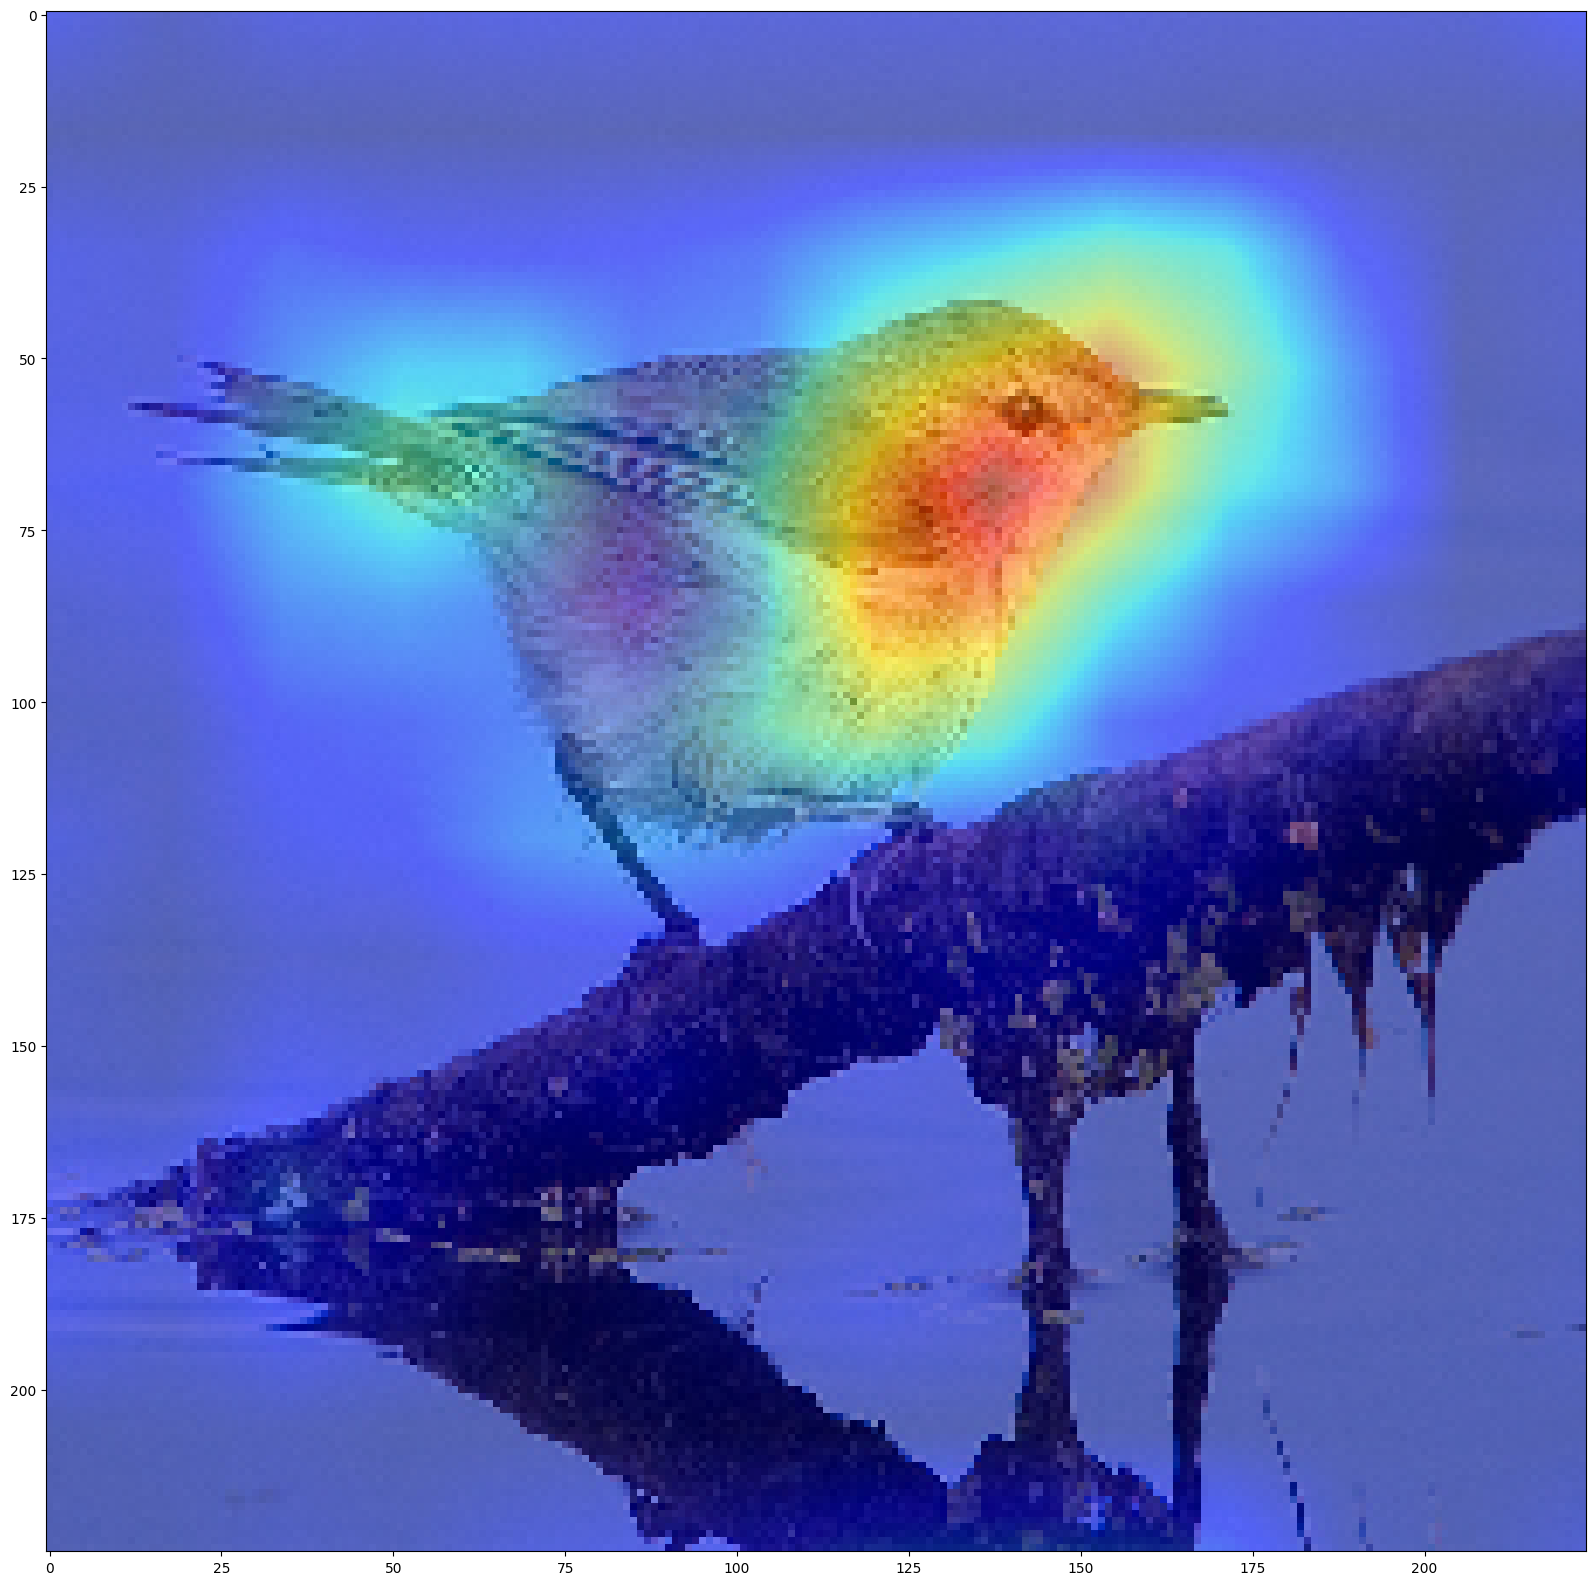

In [60]:
gradCAM(filenames_animals[0])

1/1 [==============================] - 0s 20ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n02096051', 'Airedale', 0.8946058), ('n02095314', 'wire-haired_fox_terrier', 0.021226704), ('n02097209', 'standard_schnauzer', 0.015890941)]]
Solution Index:  191


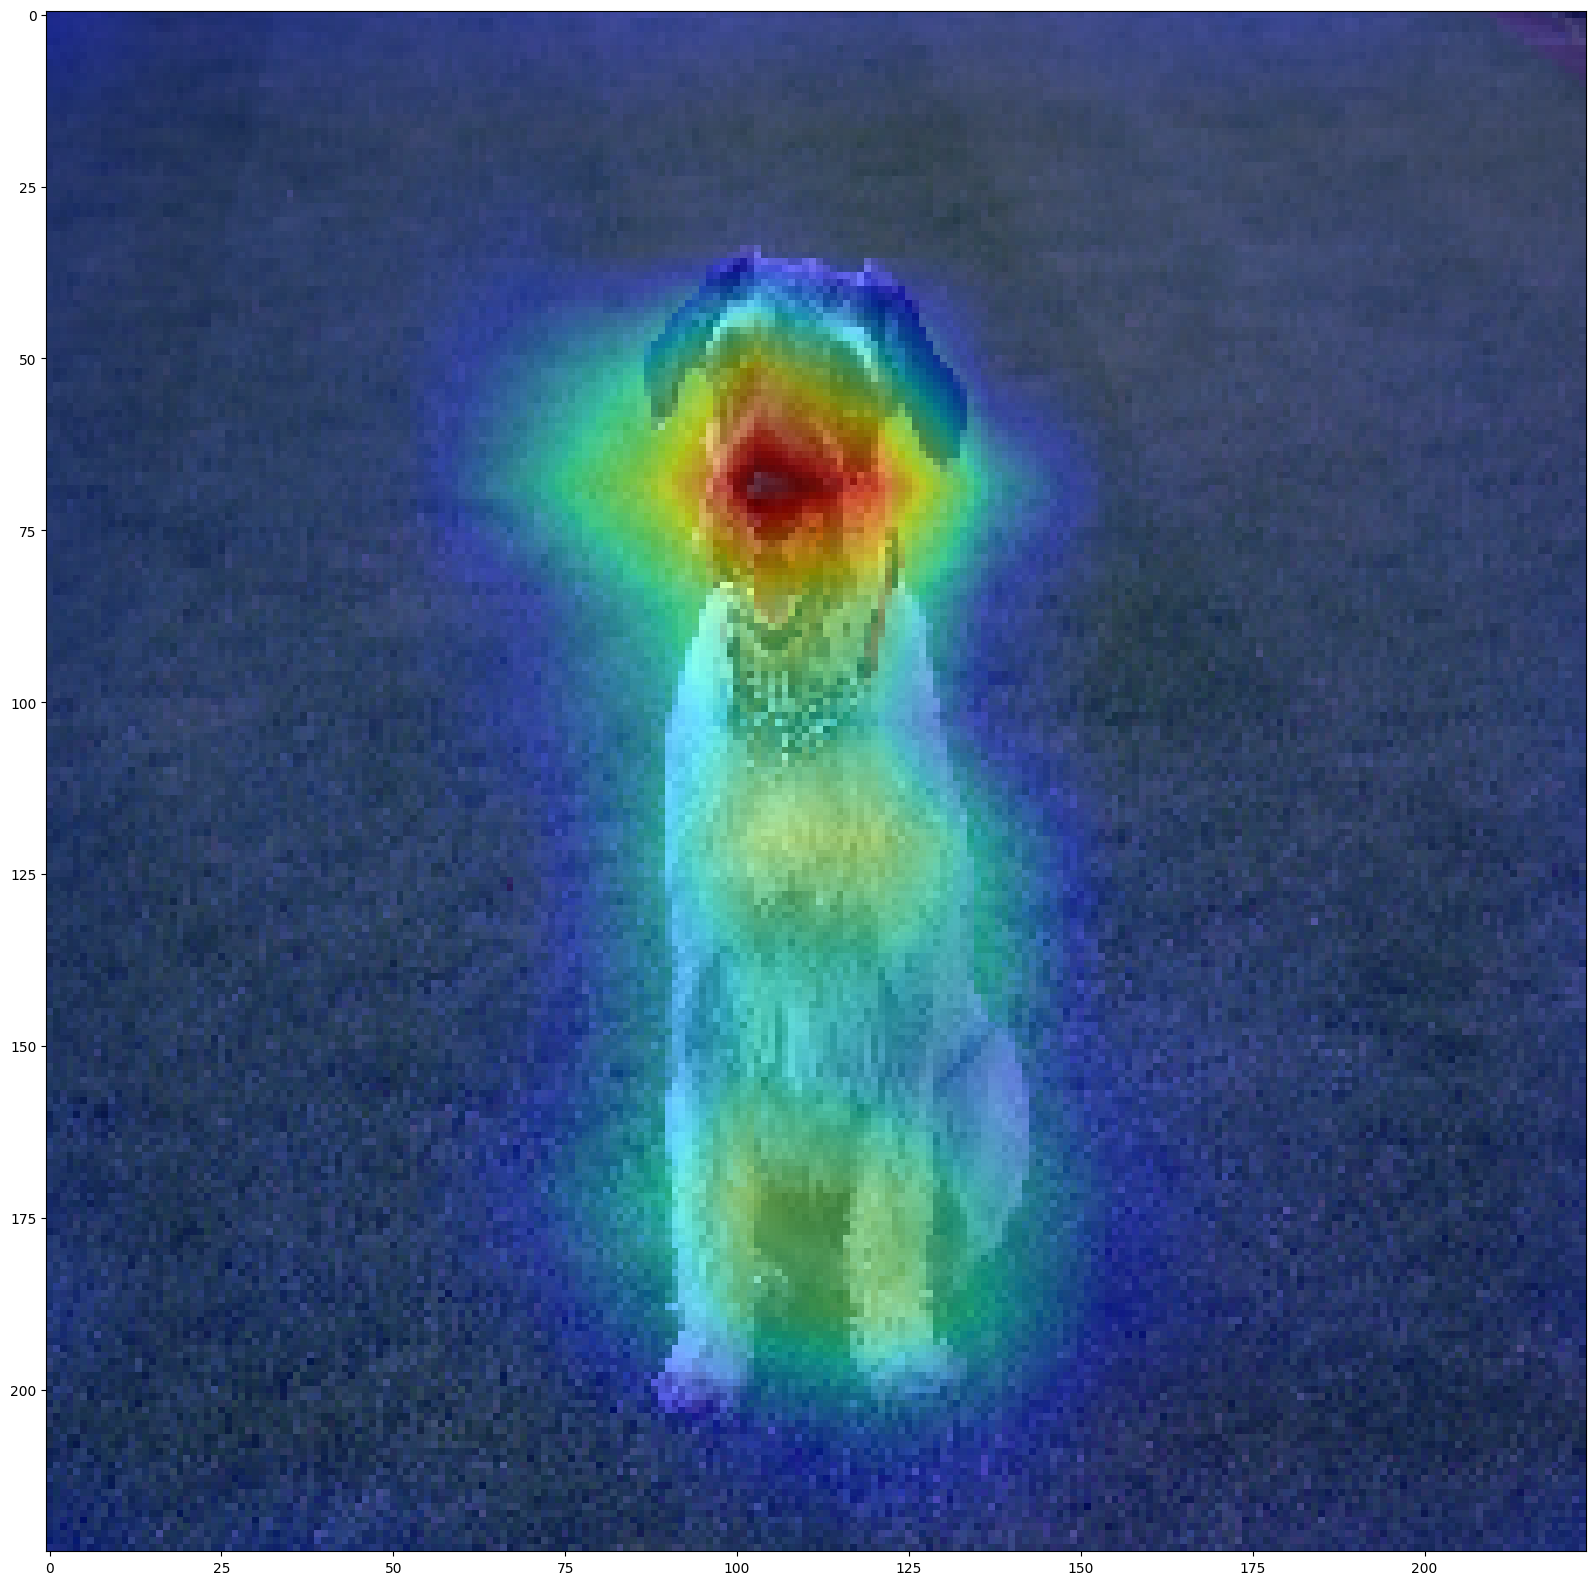

In [61]:
gradCAM(filenames_animals[1])

1/1 [==============================] - 0s 21ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n01828970', 'bee_eater', 0.9490904), ('n01820546', 'lorikeet', 0.016216928), ('n01843383', 'toucan', 0.013921008)]]
Solution Index:  92


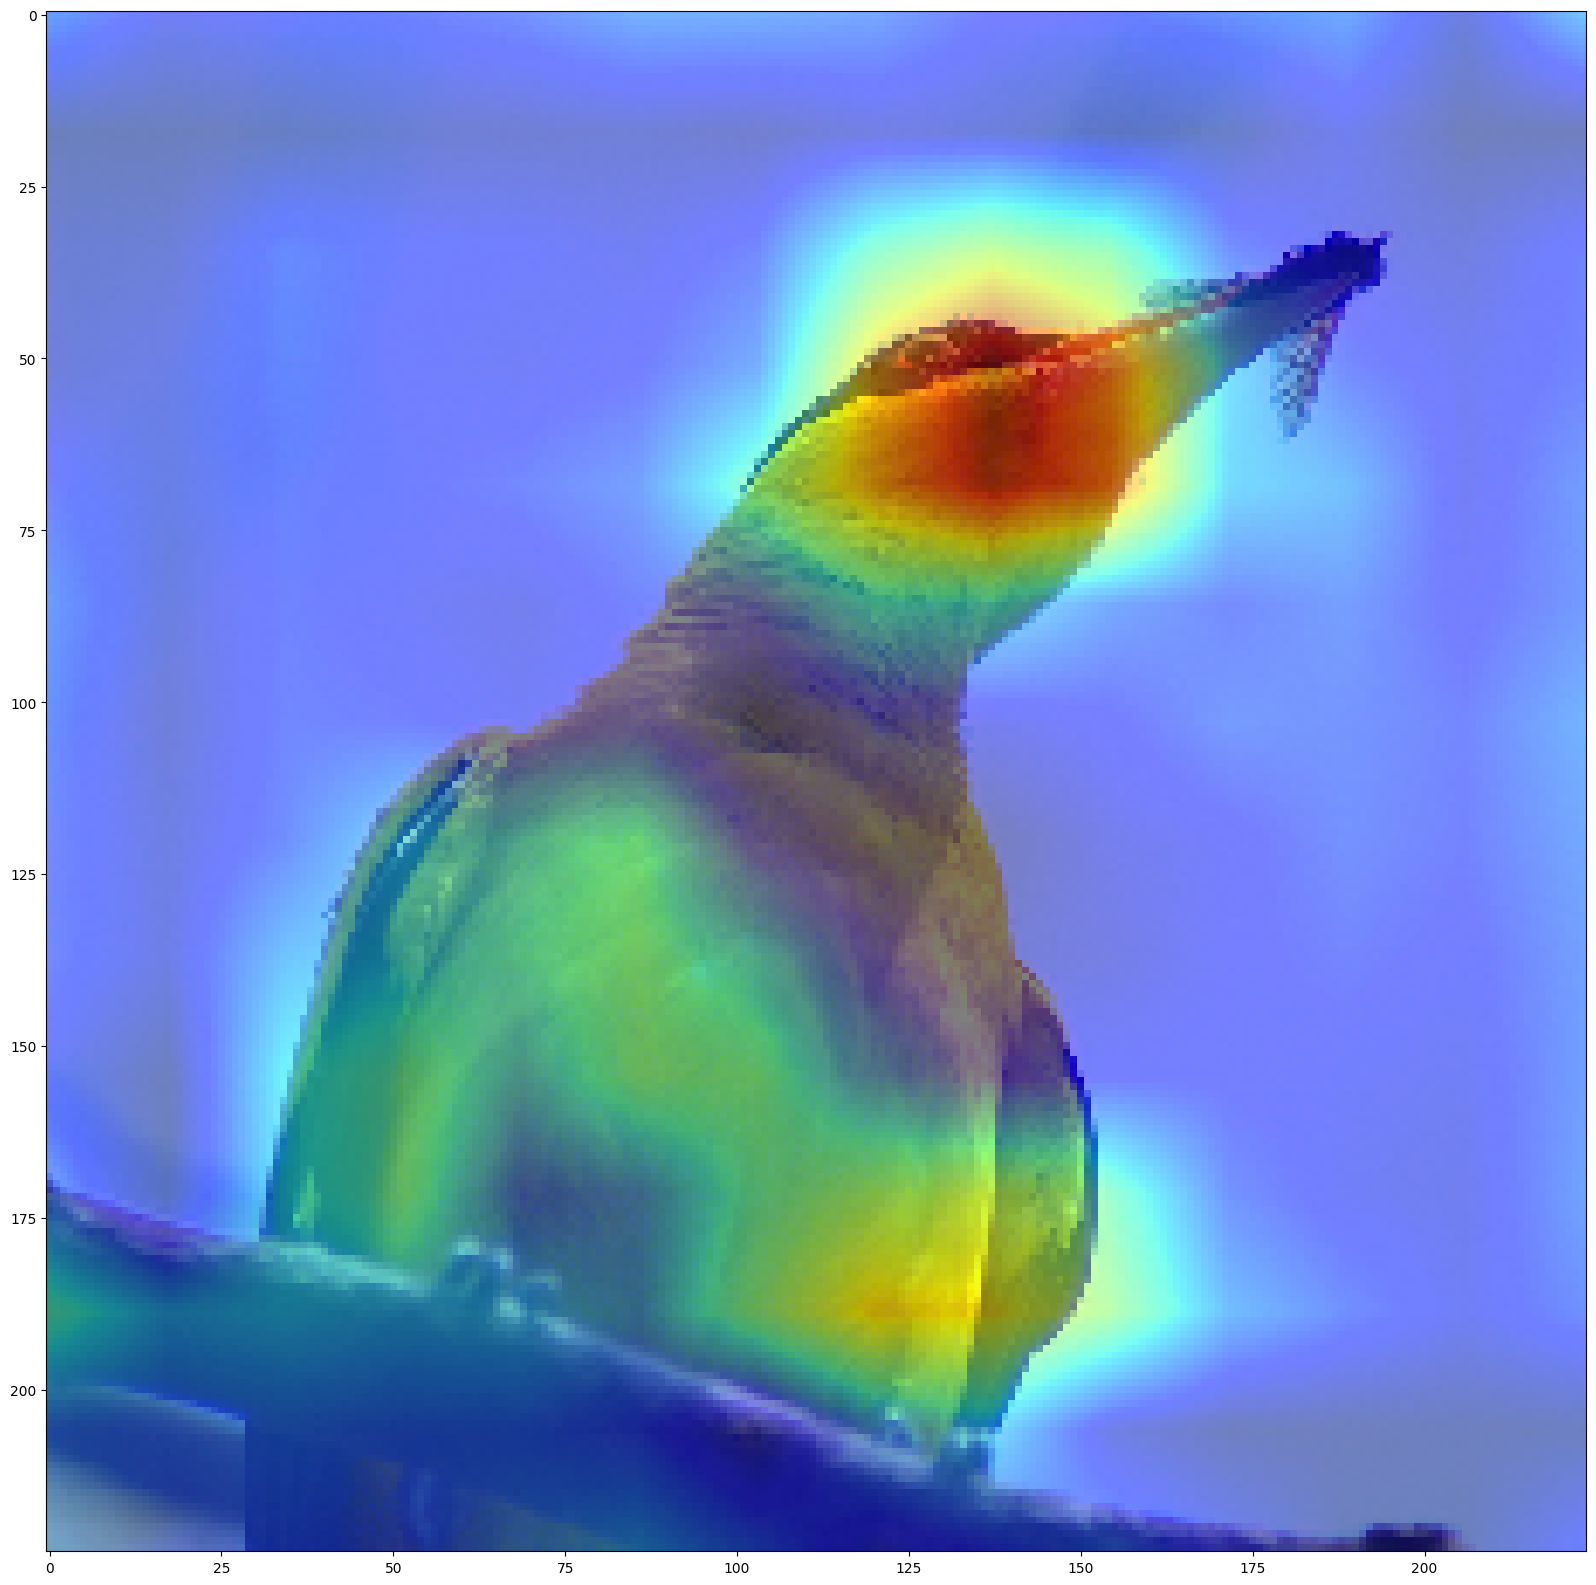

In [62]:
gradCAM(filenames_animals[2])

1/1 [==============================] - 0s 38ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n03344393', 'fireboat', 0.24259326), ('n04311004', 'steel_arch_bridge', 0.1766355), ('n04606251', 'wreck', 0.12831818)]]
Solution Index:  554


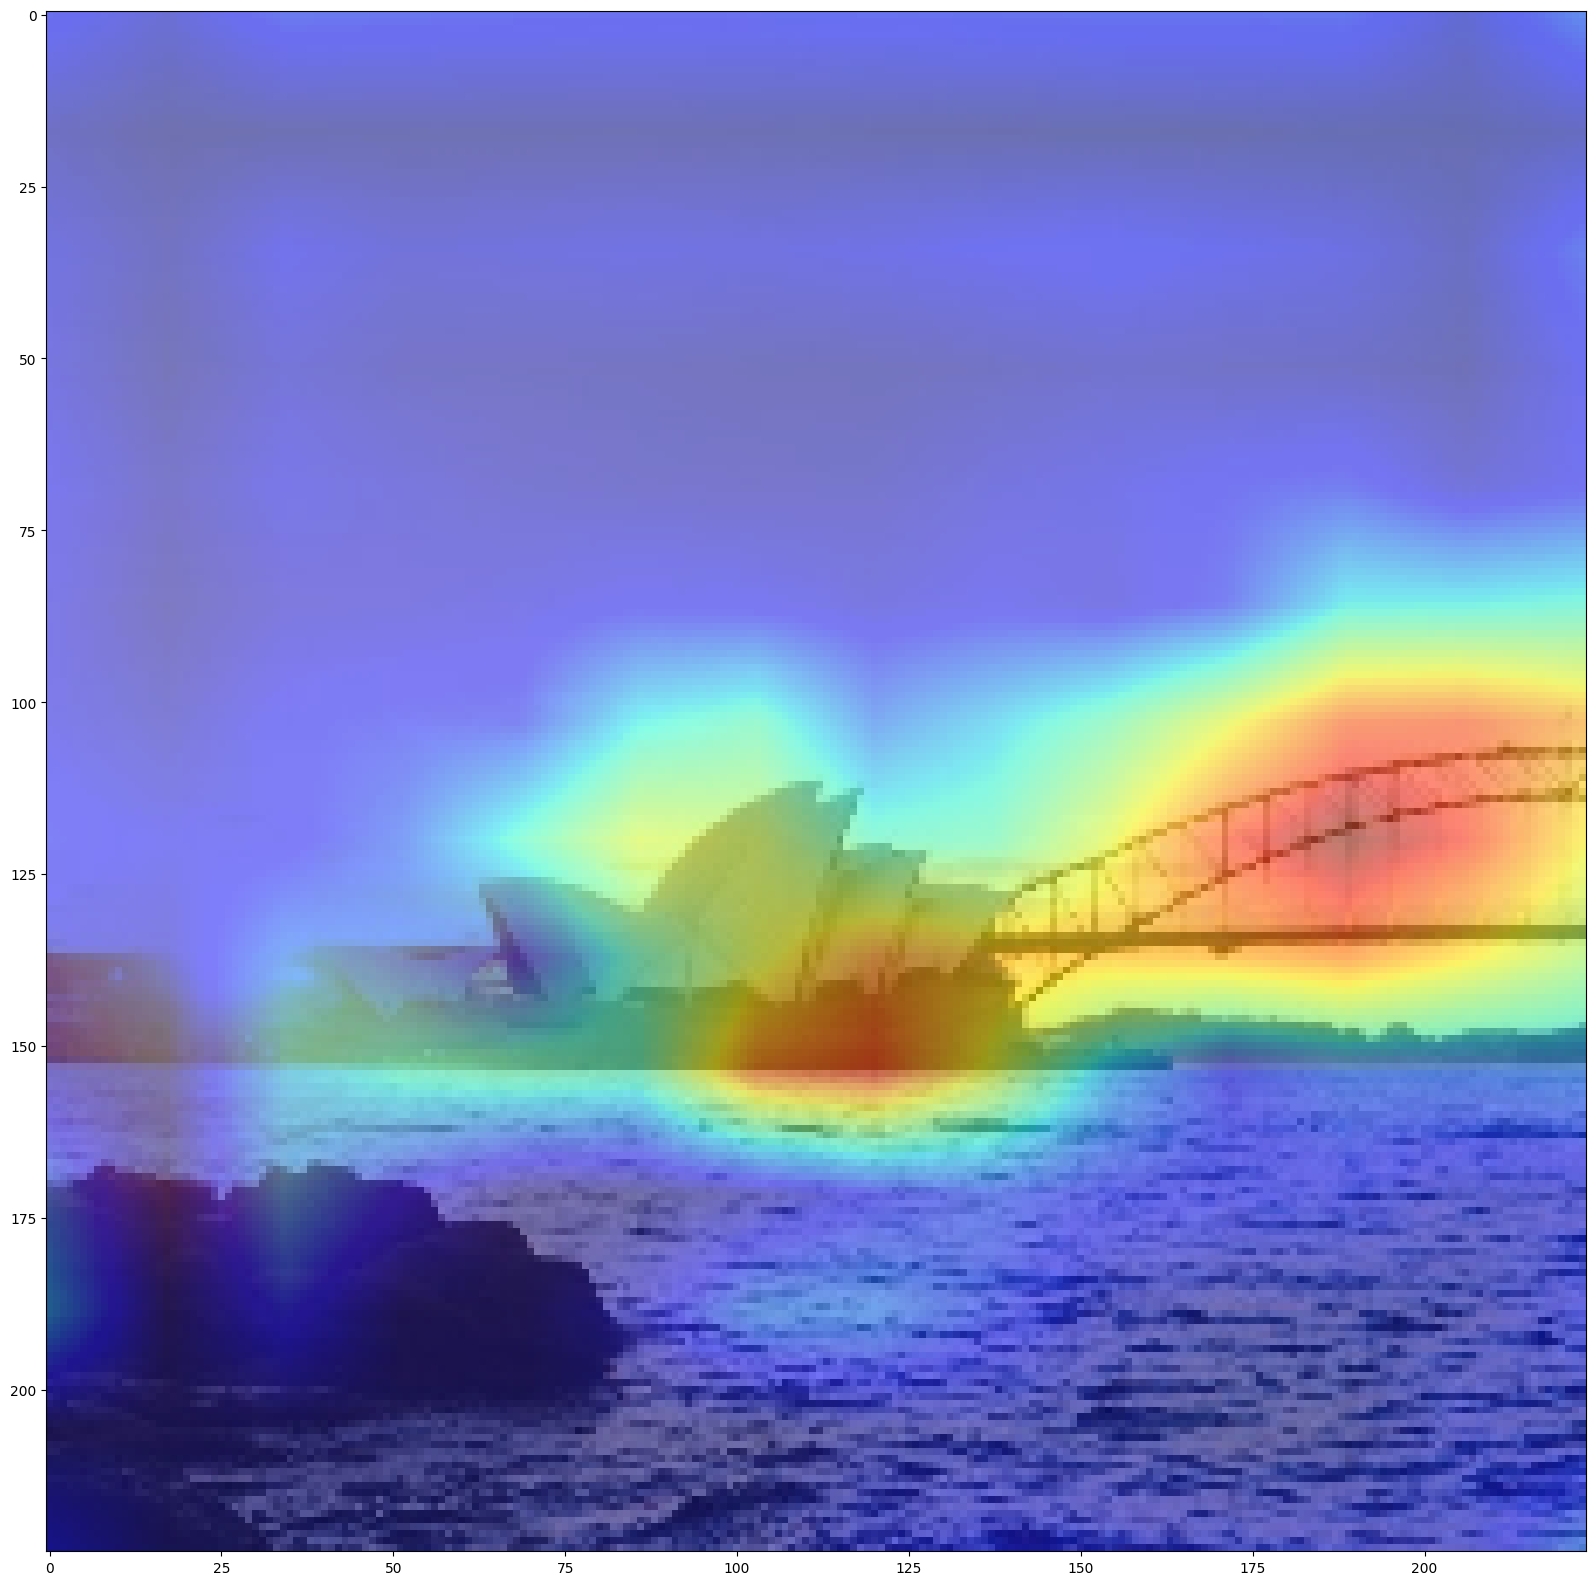

In [63]:
gradCAM(filenames_bridge[0])

1/1 [==============================] - 0s 121ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n04311004', 'steel_arch_bridge', 0.40573585), ('n04356056', 'sunglasses', 0.098770365), ('n02879718', 'bow', 0.09855987)]]
Solution Index:  821


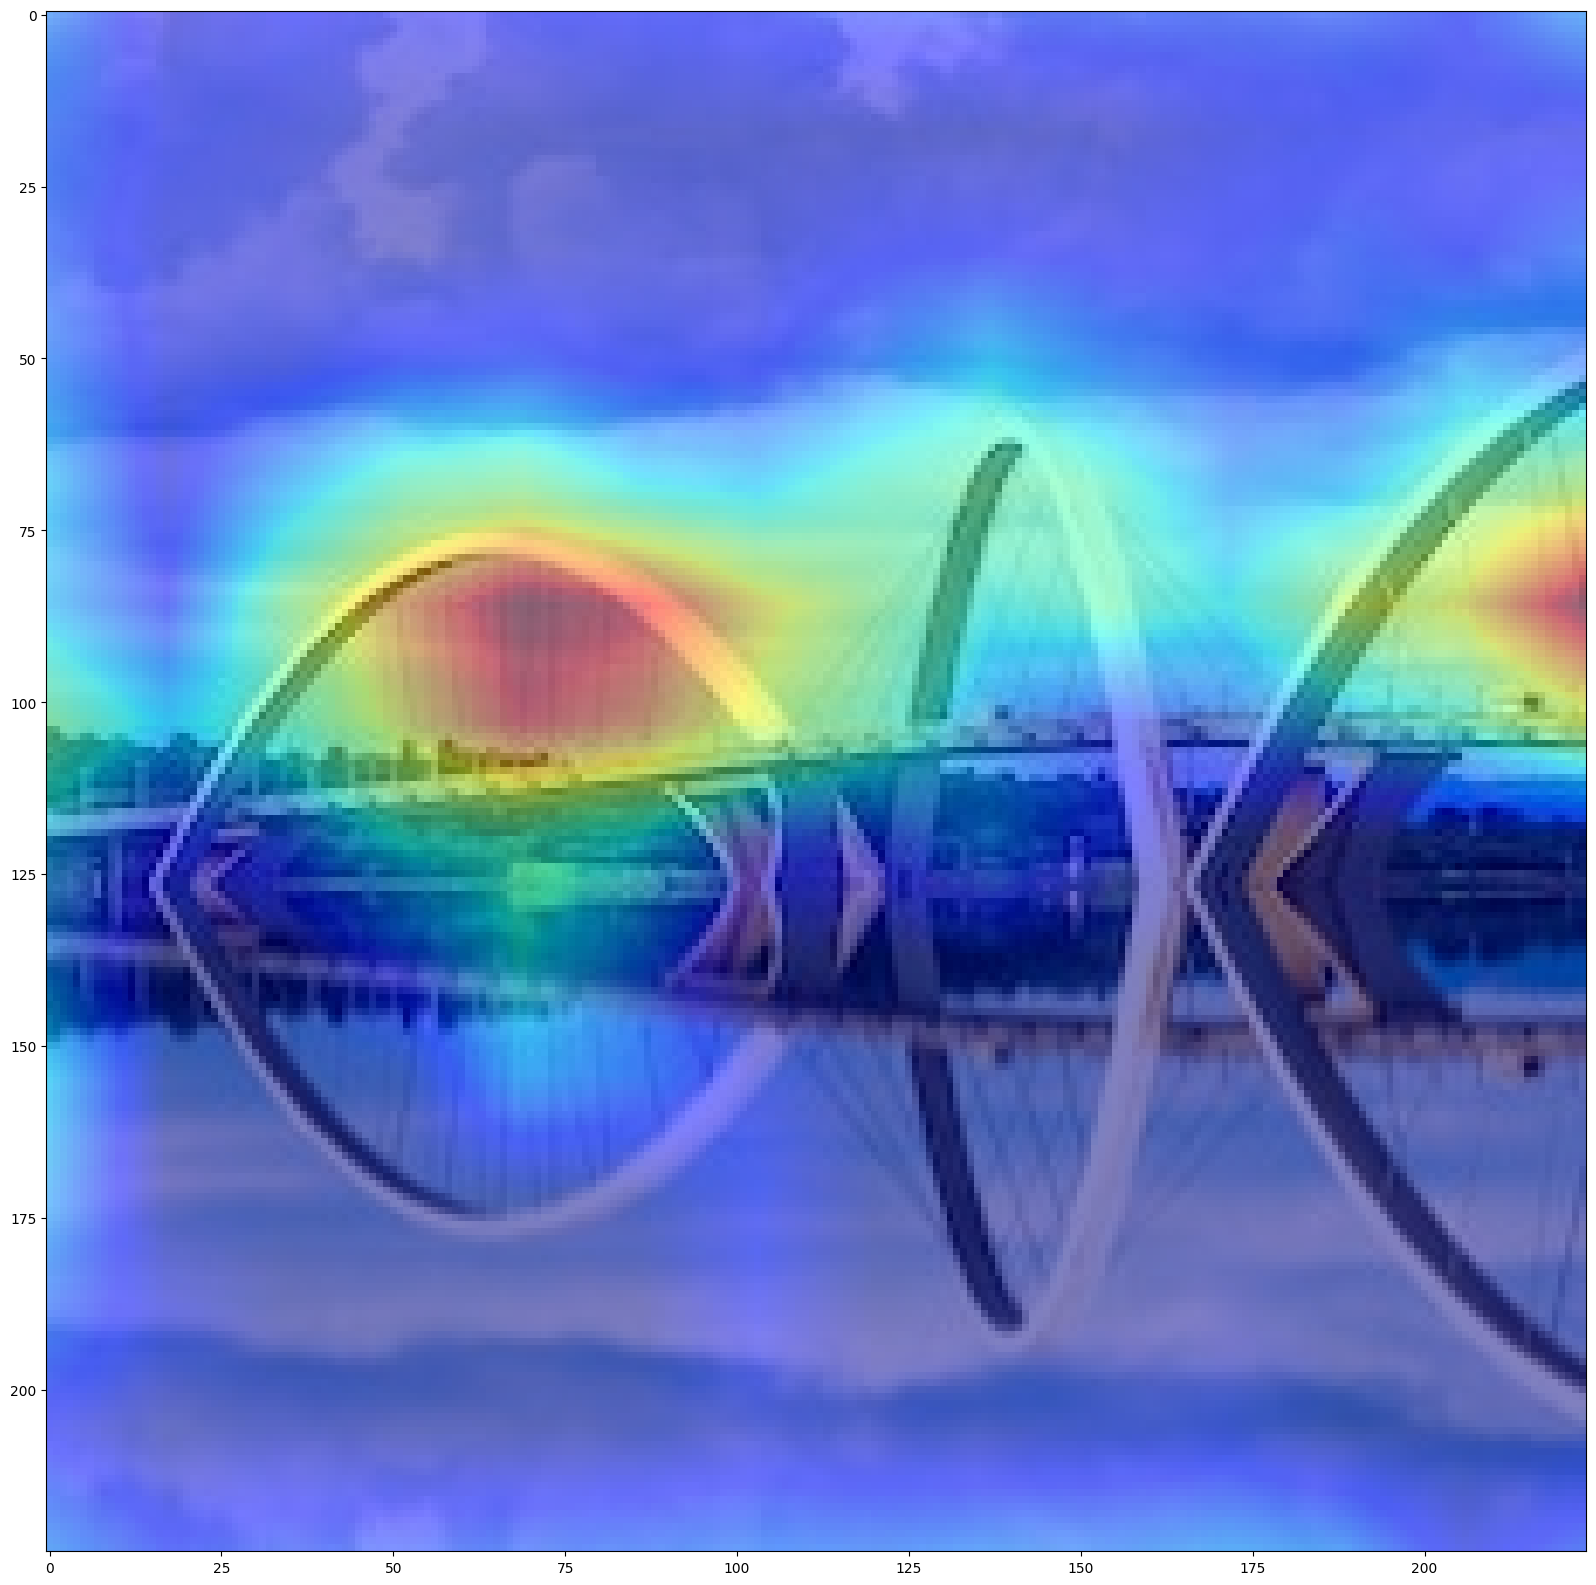

In [64]:
gradCAM(filenames_bridge[1])

1/1 [==============================] - 0s 38ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n04366367', 'suspension_bridge', 0.65476143), ('n03933933', 'pier', 0.105135955), ('n02894605', 'breakwater', 0.09074555)]]
Solution Index:  839


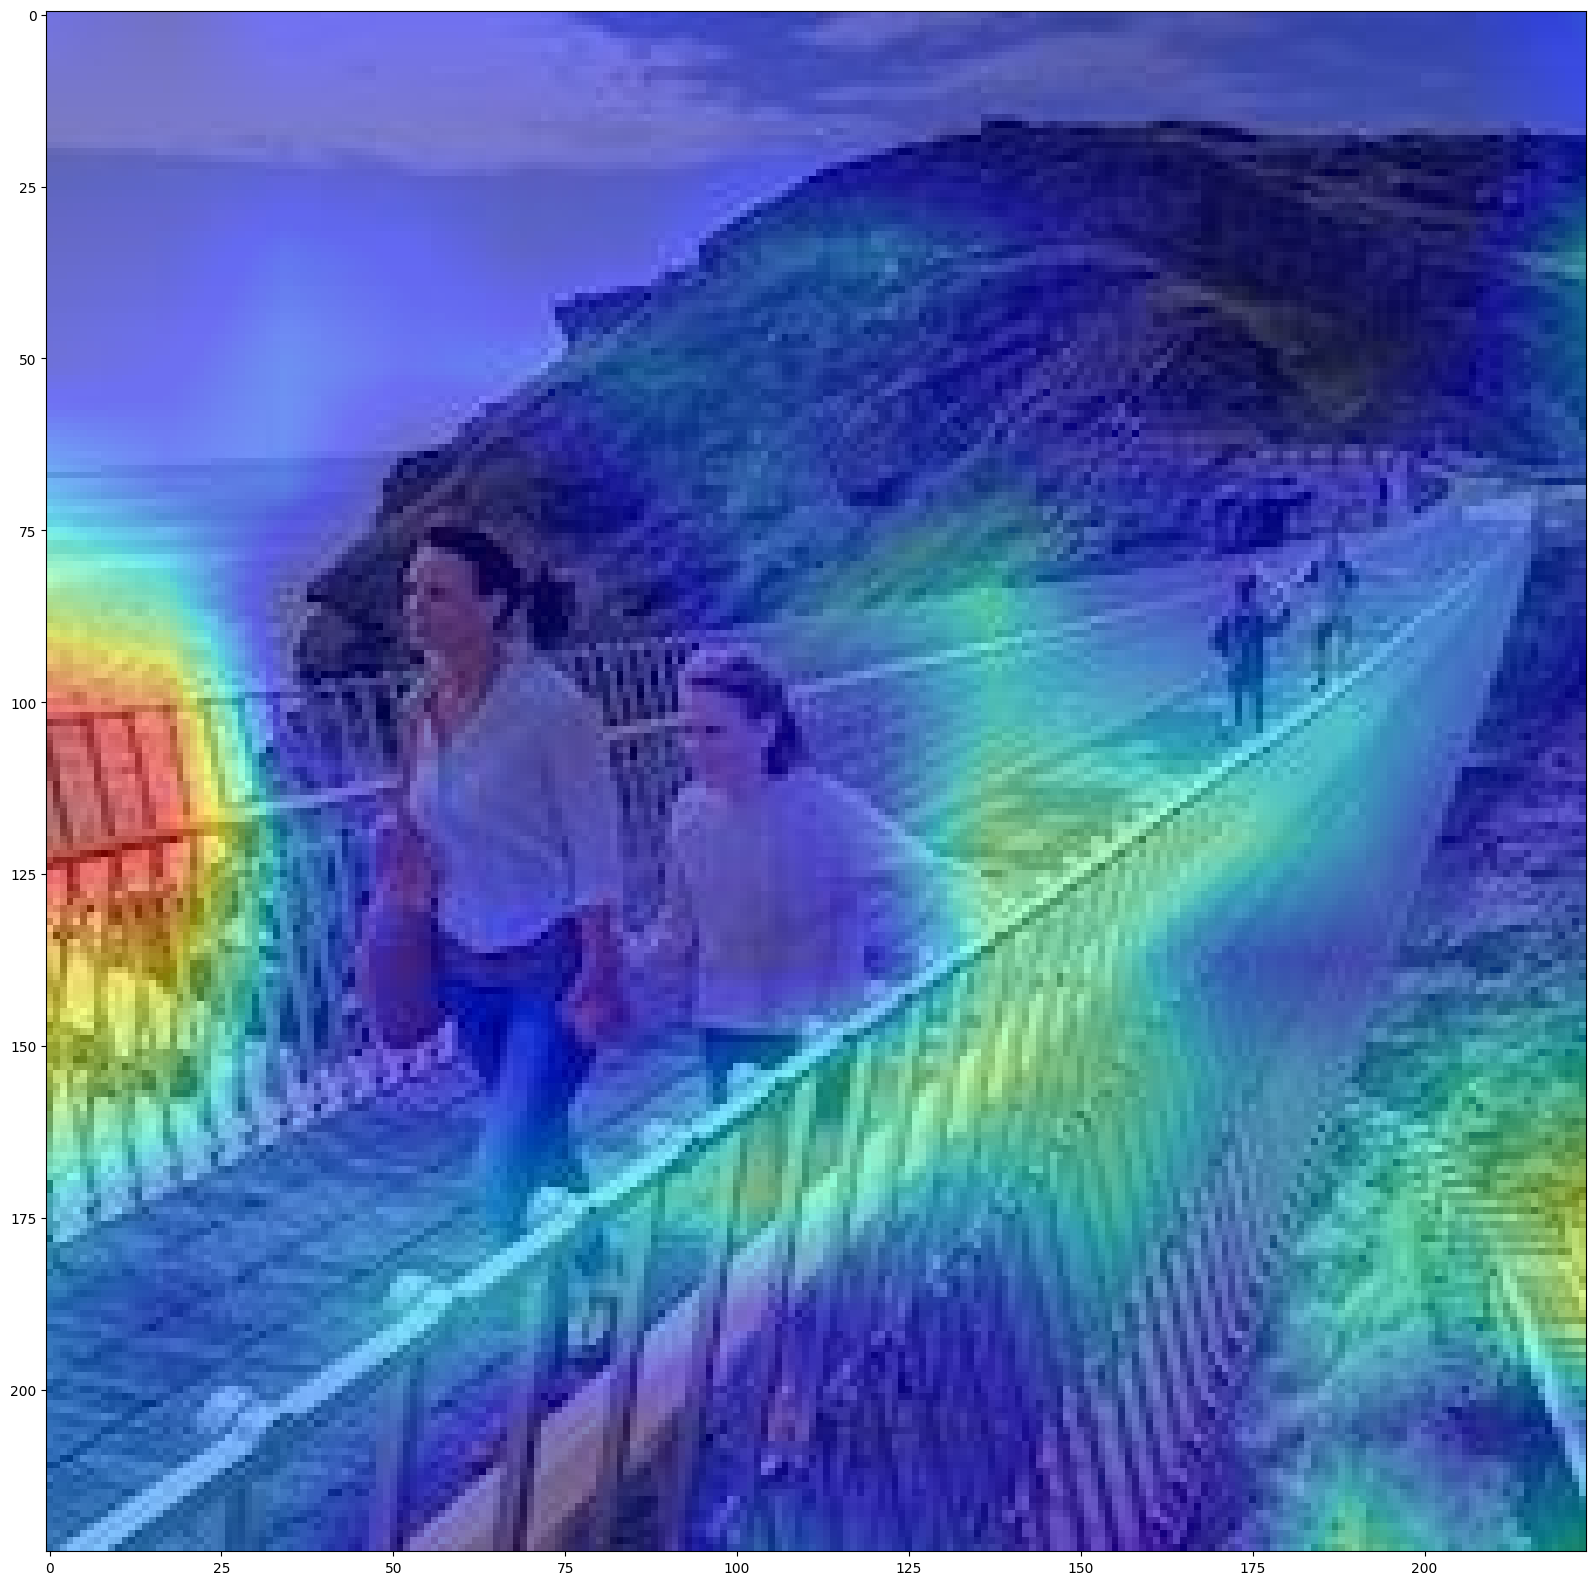

In [65]:
gradCAM(filenames_bridge[2])

1/1 [==============================] - 0s 70ms/step


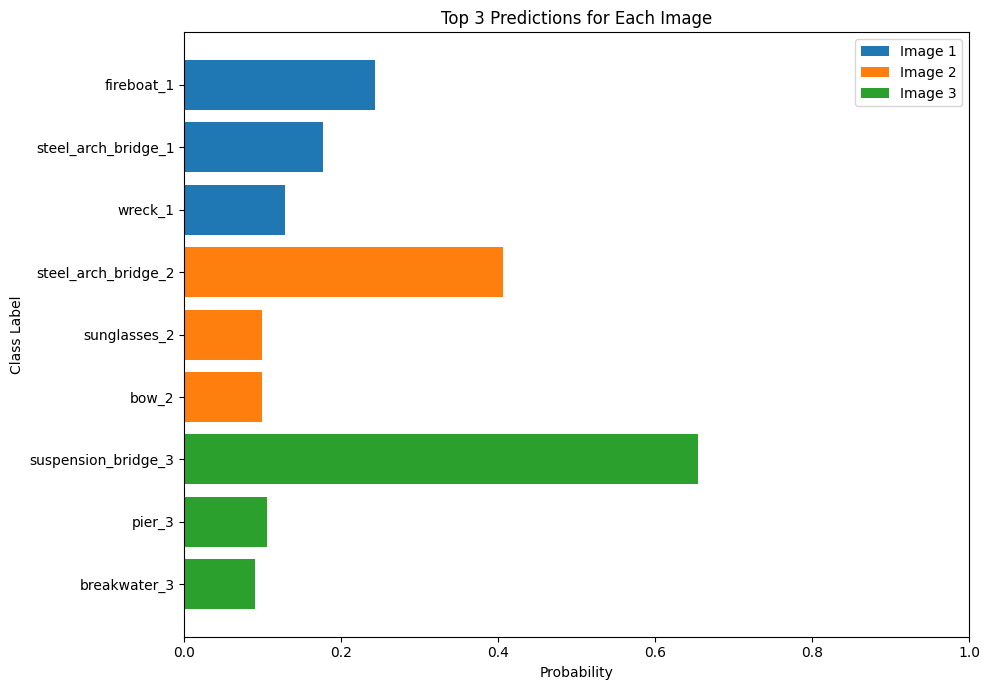

In [66]:
def prediction_img(filename):
  image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))

  img_prep = img_to_array(image)

  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)

  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)

  # result
  return decode_predictions(img_prediction, top=3)



all_results = [prediction_img(filename) for filename in filenames_bridge]

plt.figure(figsize=(10, 7))

# Loop through each prediction result and plot the bars
for idx, prediction_result in enumerate(all_results):
    labels = [item[1] for item in prediction_result[0]]
    probabilities = [item[2] for item in prediction_result[0]]
    plt.barh([label + f'_{idx+1}' for label in labels], probabilities, label=f'Image {idx+1}')

plt.xlabel('Probability')
plt.ylabel('Class Label')
plt.title('Top 3 Predictions for Each Image')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

# Activation Maximization

So far, we visualized activations of images, i.e. we focused on visualizations of inner network representations for given image data.

We can also visualize properties of the network itself. A popular method is the activation maximization, where we seek an image that would maximize a given neuron inside the network.

For this, we solve the maximization problem:
\begin{equation}
x^{\ast} = {\arg \max}_{x} z(x)
\end{equation}
where $z(x)$ is the value of an arbitrary neuron (or a set of neurons, e.g. the neurons in one feature map) in the network.

Typically, $z(x)=S_c(x)$ is the value of the output layer for one particular class. We therefore seek the image that maximizes the output for a particular class (e.g. the output for `water_ouzel`, `index: 20`).

<ipython-input-69-b7afc60a0eb8>:16: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[53.87993621826172]],	Regularization: [('TotalVariation2D', [4.624413967132568]), ('Norm', [38.10818099975586])]
Steps: 100	Scores: [[102.60803985595703]],	Regularization: [('TotalVariation2D', [4.7820515632629395]), ('Norm', [38.068138122558594])]
Steps: 150	Scores: [[128.19766235351562]],	Regularization: [('TotalVariation2D', [5.085963726043701]), ('Norm', [38.04855728149414])]
Steps: 200	Scores: [[123.68634033203125]],	Regularization: [('TotalVariation2D', [5.384045124053955]), ('Norm', [38.02619552612305])]


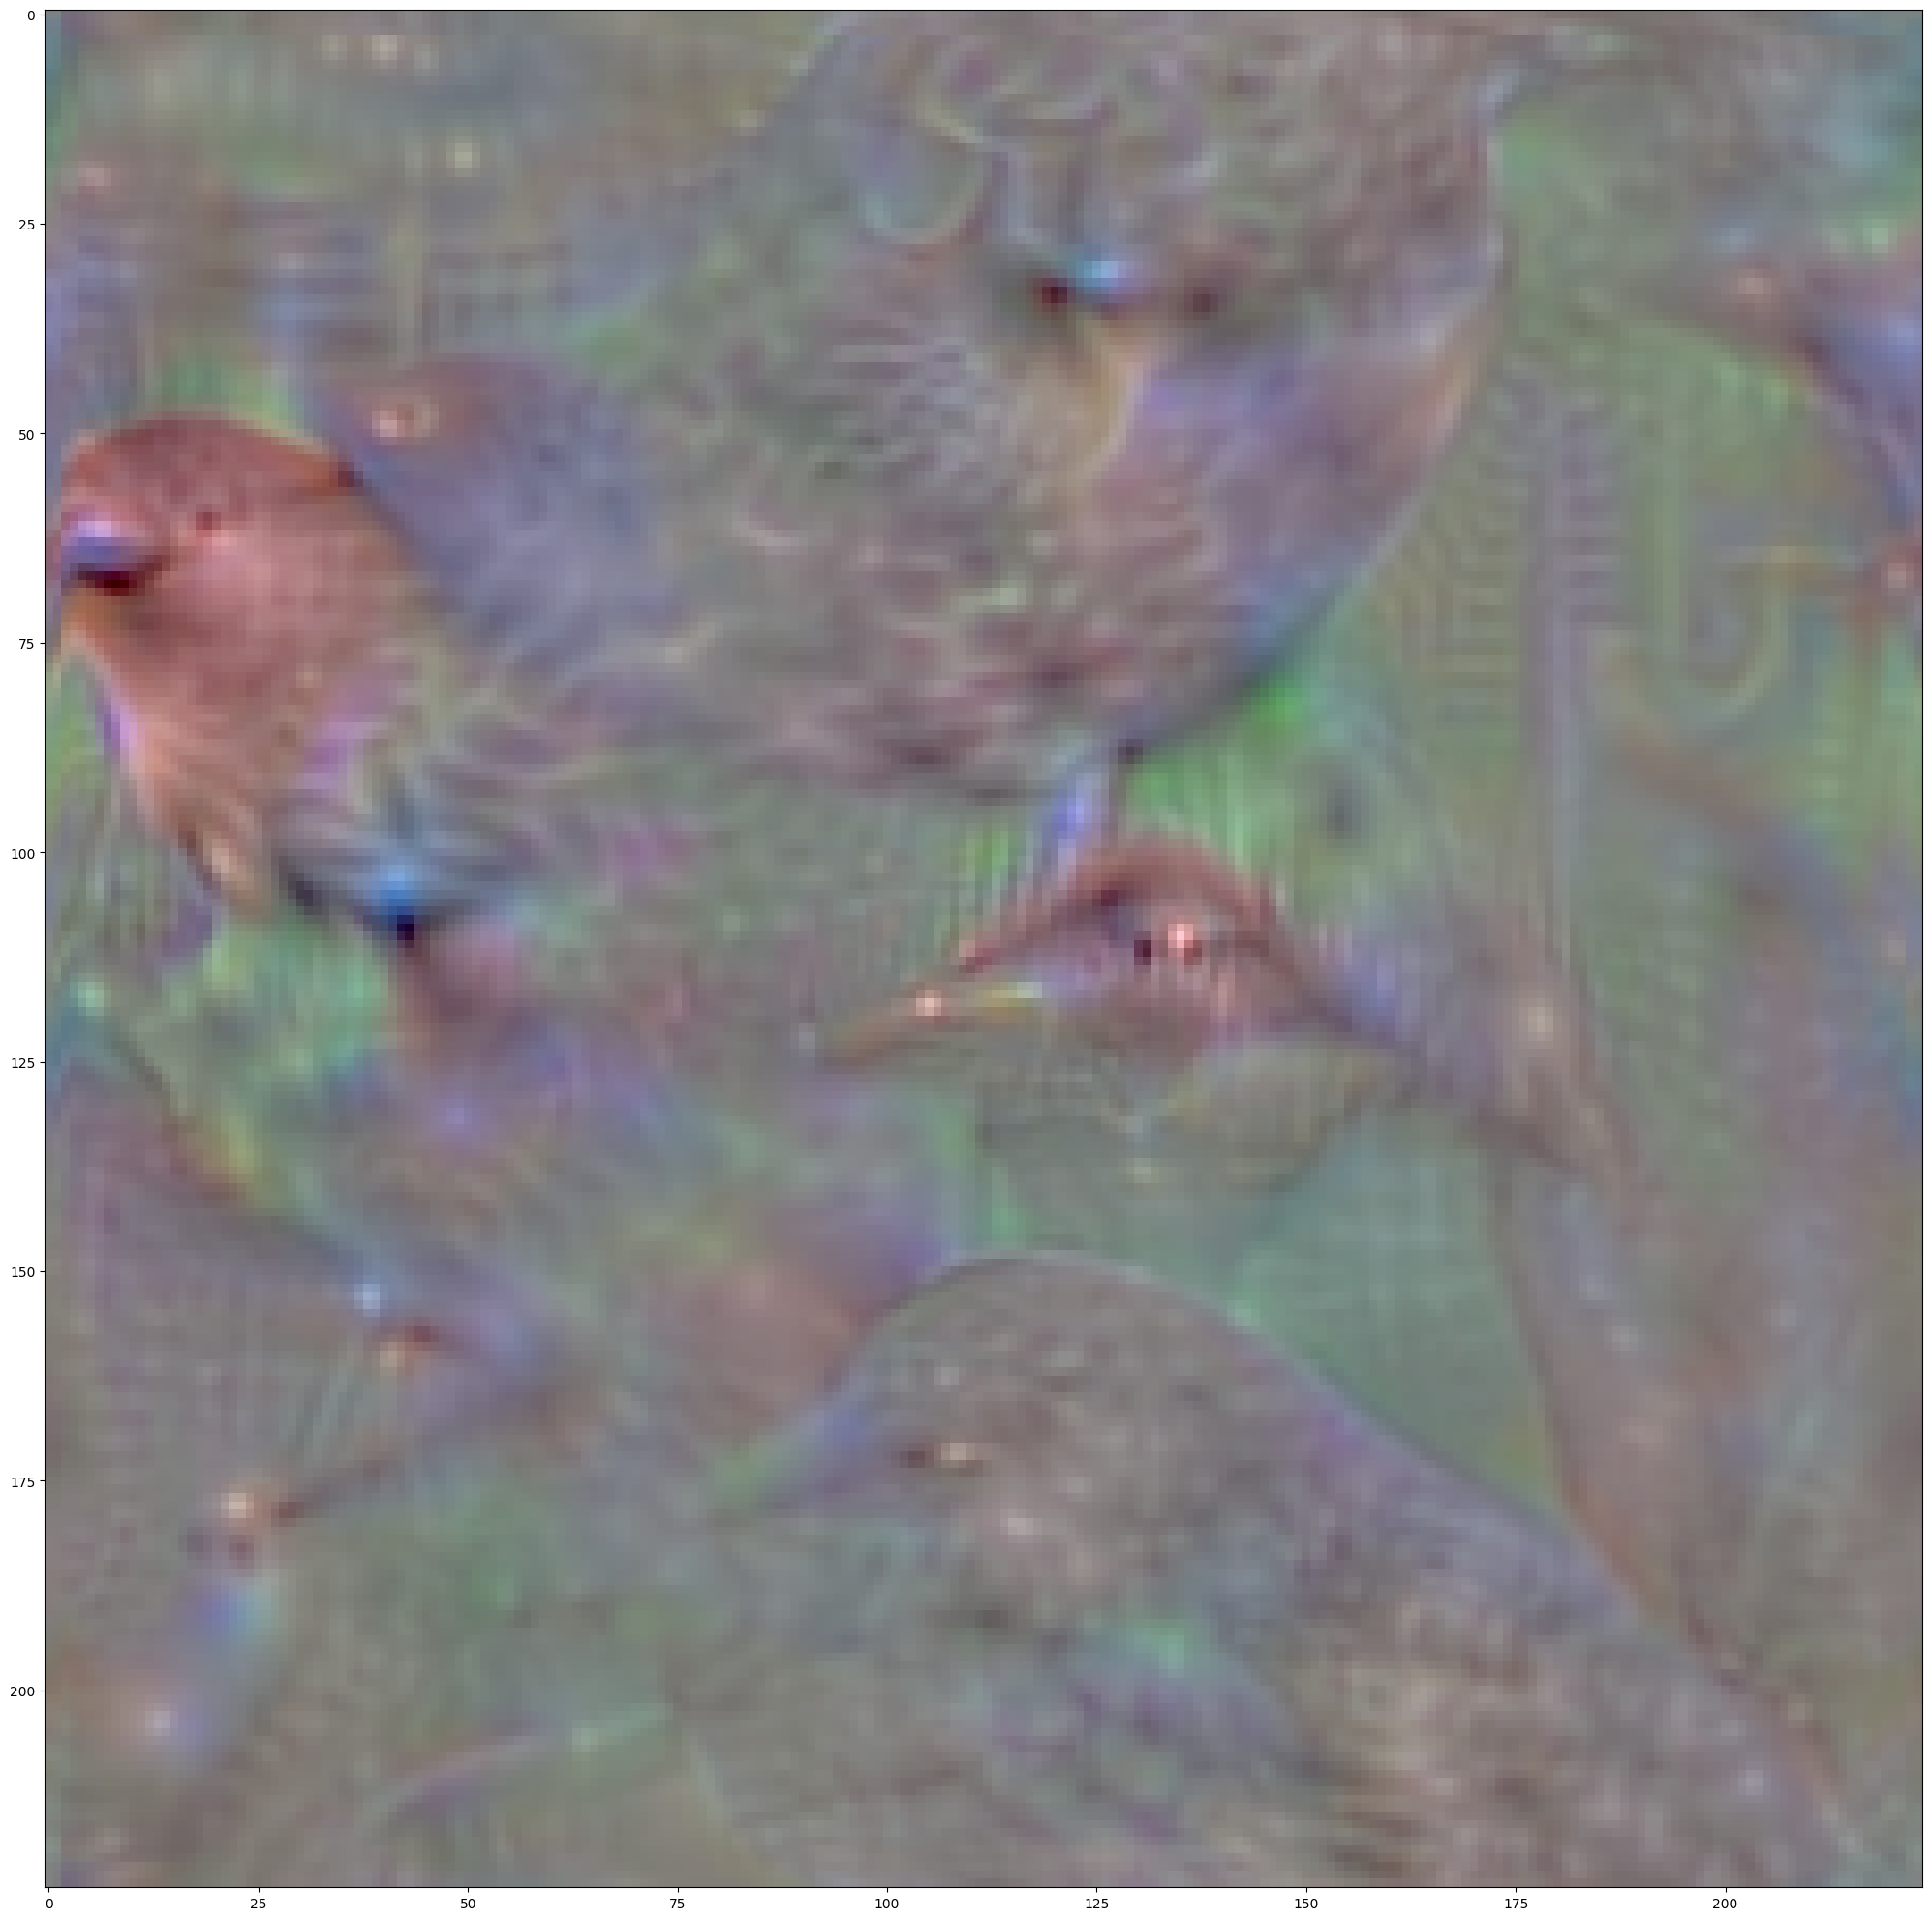

In [69]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 20

from tf_keras_vis.activation_maximization import ActivationMaximization

def activation_max(index):
  activation_maximization = ActivationMaximization(model,
                                                  model_modifier,
                                                  clone=False)

  def loss(output):
      return output[:, index]

  from tf_keras_vis.utils.callbacks import Print

  activation = activation_maximization(loss, callbacks=[Print(interval=50)])
  generated_img = activation[0].numpy().astype(np.uint8)

  plt.imshow(generated_img)
  plt.tight_layout()

activation_max(INDEX)


<ipython-input-69-b7afc60a0eb8>:16: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[84.16920471191406]],	Regularization: [('TotalVariation2D', [5.051318645477295]), ('Norm', [38.225215911865234])]
Steps: 100	Scores: [[131.90005493164062]],	Regularization: [('TotalVariation2D', [5.426227569580078]), ('Norm', [38.1976432800293])]
Steps: 150	Scores: [[182.9558868408203]],	Regularization: [('TotalVariation2D', [6.523037910461426]), ('Norm', [38.20563888549805])]
Steps: 200	Scores: [[212.28219604492188]],	Regularization: [('TotalVariation2D', [6.123854637145996]), ('Norm', [38.240203857421875])]


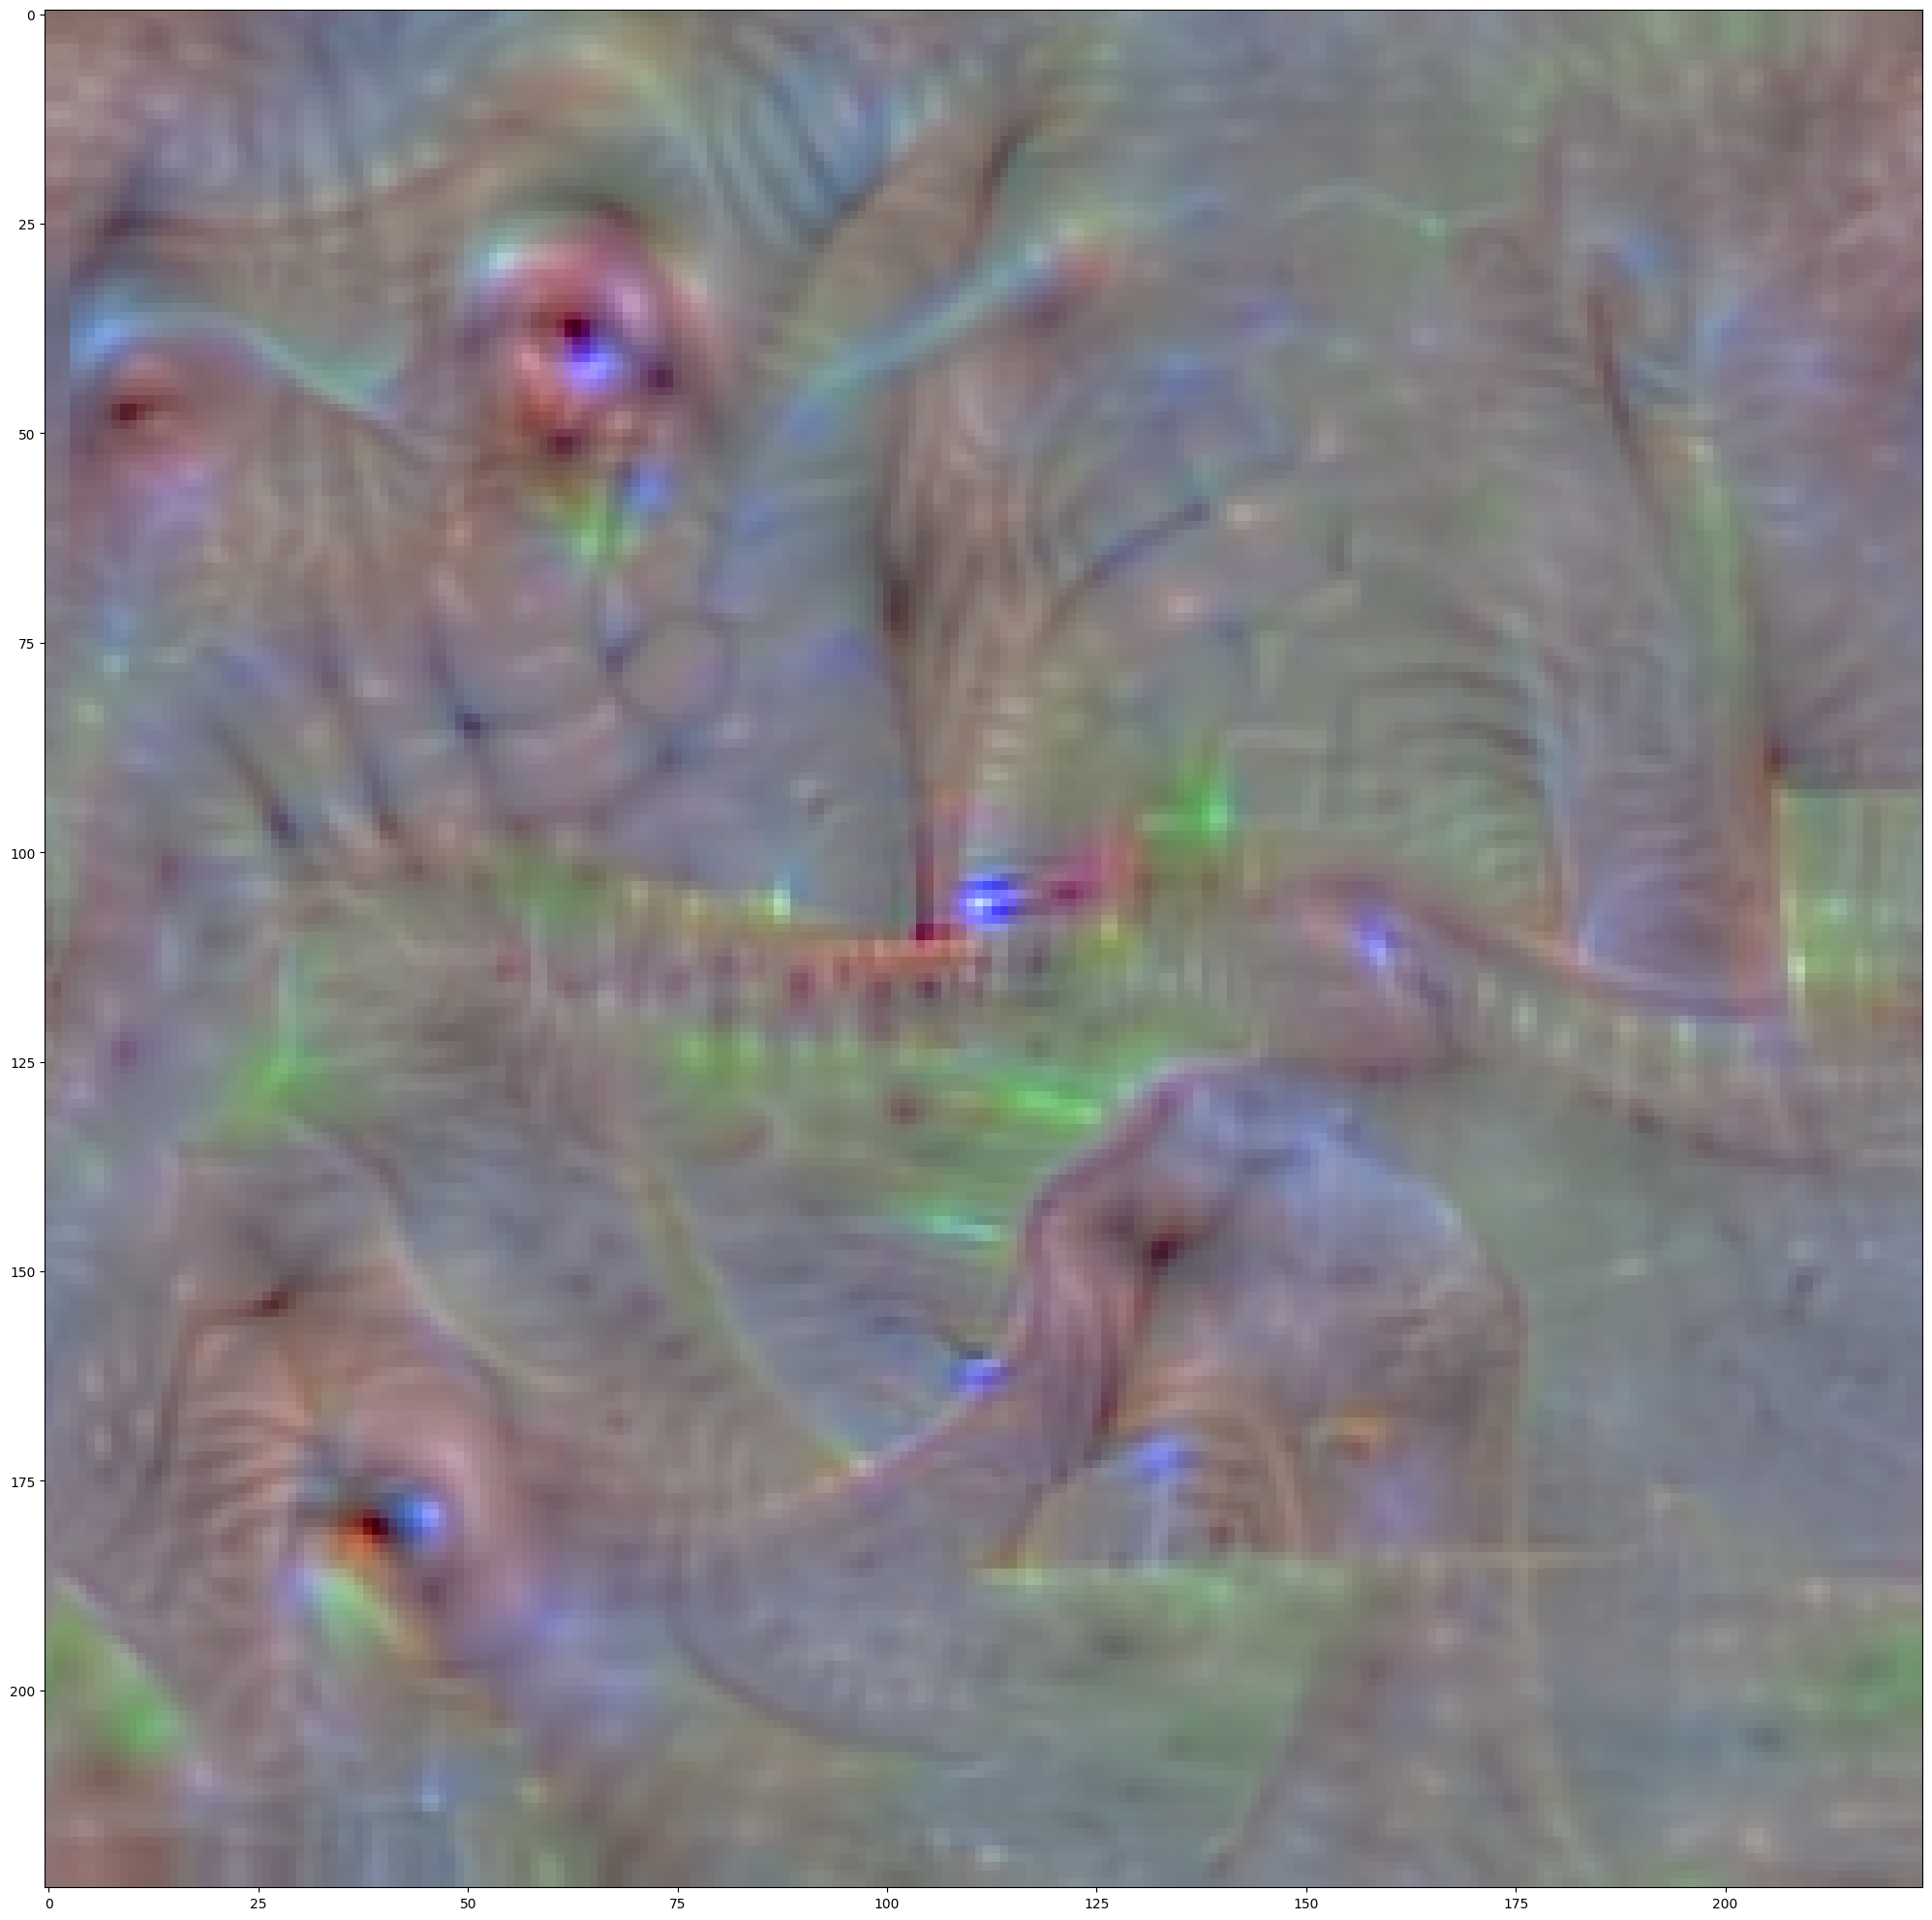

In [70]:
activation_max(385)

<ipython-input-69-b7afc60a0eb8>:16: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[68.89820098876953]],	Regularization: [('TotalVariation2D', [4.440844535827637]), ('Norm', [38.23039627075195])]
Steps: 100	Scores: [[103.1792221069336]],	Regularization: [('TotalVariation2D', [4.625400066375732]), ('Norm', [38.18610763549805])]
Steps: 150	Scores: [[142.9720458984375]],	Regularization: [('TotalVariation2D', [5.971840858459473]), ('Norm', [38.18458557128906])]
Steps: 200	Scores: [[159.35525512695312]],	Regularization: [('TotalVariation2D', [5.426419734954834]), ('Norm', [38.18287658691406])]


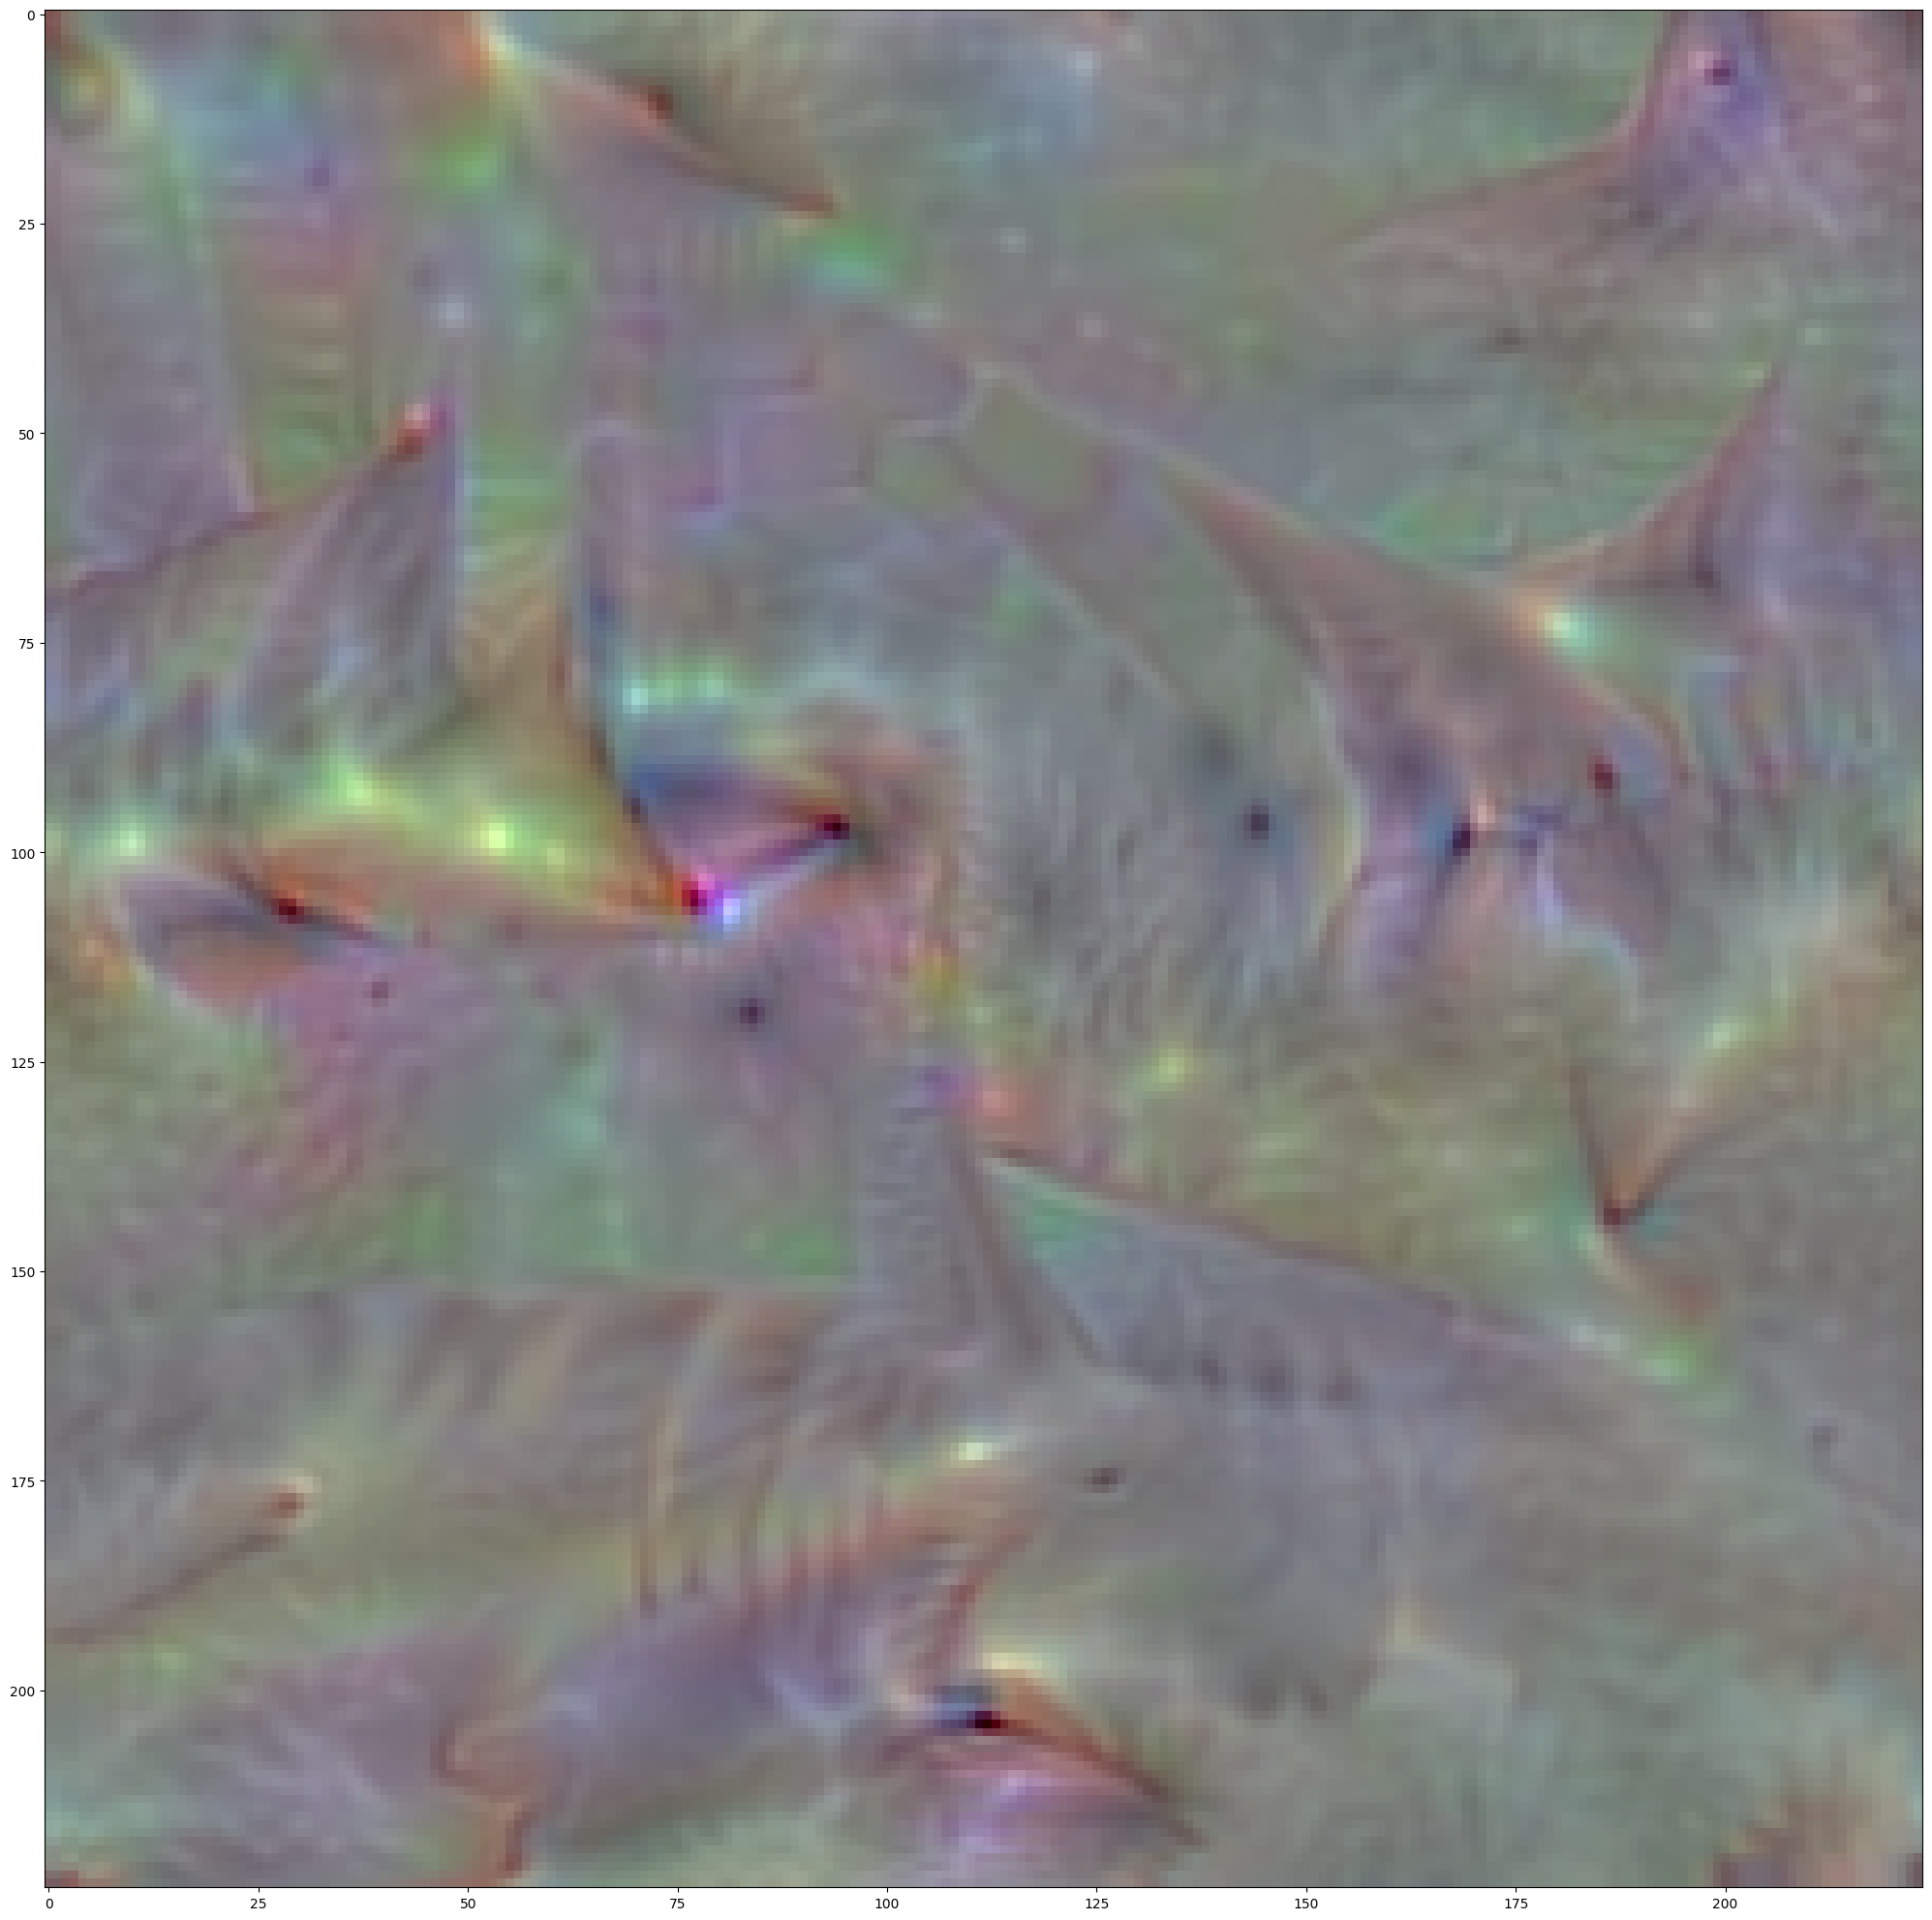

In [71]:
activation_max(2)

<ipython-input-69-b7afc60a0eb8>:16: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[31.76970863342285]],	Regularization: [('TotalVariation2D', [3.842310905456543]), ('Norm', [38.25920867919922])]
Steps: 100	Scores: [[66.88577270507812]],	Regularization: [('TotalVariation2D', [3.869908332824707]), ('Norm', [38.19878387451172])]
Steps: 150	Scores: [[84.04931640625]],	Regularization: [('TotalVariation2D', [4.144362449645996]), ('Norm', [38.15019607543945])]
Steps: 200	Scores: [[92.84571838378906]],	Regularization: [('TotalVariation2D', [4.171112060546875]), ('Norm', [38.12457275390625])]


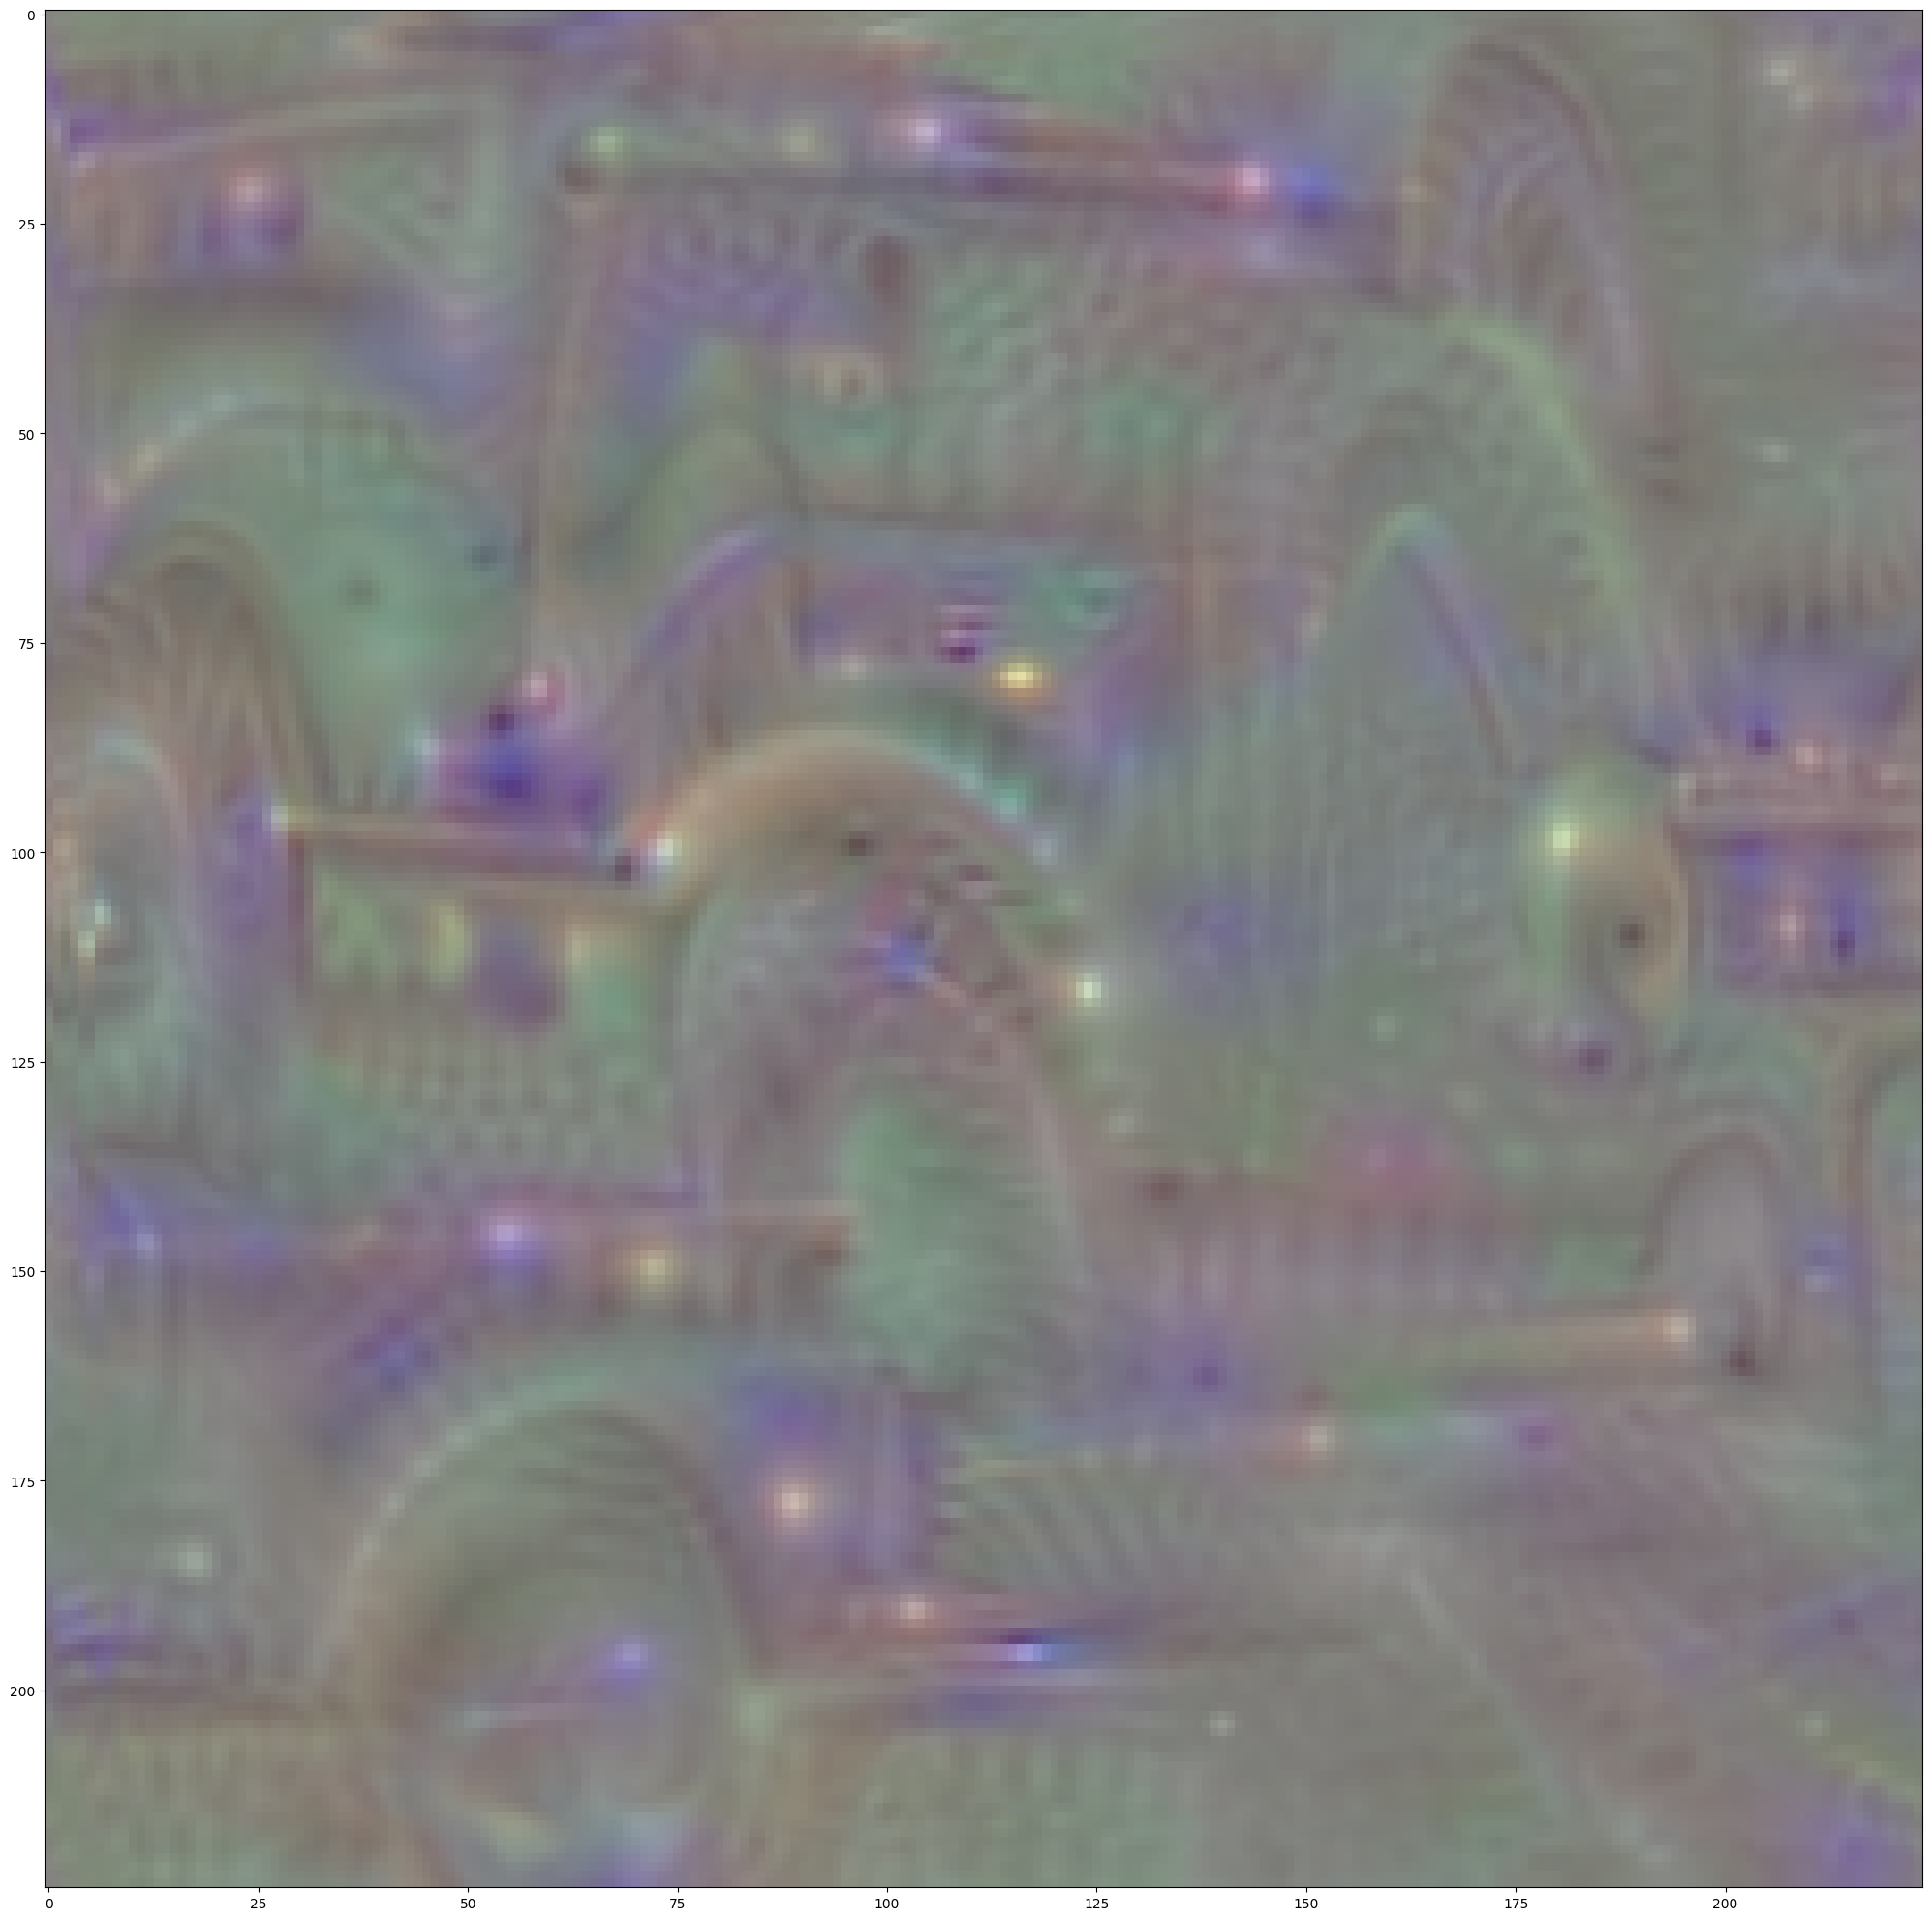

In [72]:
activation_max(555)

**Assignment**: You might want to play with this, e.g. 385: Indian elephant, 2: great white shark, 555: fire truck

Other classes can be found at:
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

**Assignment:** Generate the activation maximization image for  the same class, just as before, but for a network initialized randomly. What do you observe?

**Answer** We observe that with random weights, the activation maximization does not show any meaningul features (no beaks for birds, wheels for cars). Which makes sense as the network didn't learn anything yet.

<ipython-input-73-7d70ba6921ab>:15: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[0.4470258355140686]],	Regularization: [('TotalVariation2D', [3.2024929523468018]), ('Norm', [38.251373291015625])]
Steps: 100	Scores: [[0.4286155104637146]],	Regularization: [('TotalVariation2D', [1.3710042238235474]), ('Norm', [38.16402053833008])]
Steps: 150	Scores: [[0.42539459466934204]],	Regularization: [('TotalVariation2D', [0.8462251424789429]), ('Norm', [38.07476806640625])]
Steps: 200	Scores: [[0.42995181679725647]],	Regularization: [('TotalVariation2D', [0.5759552121162415]), ('Norm', [37.98103713989258])]


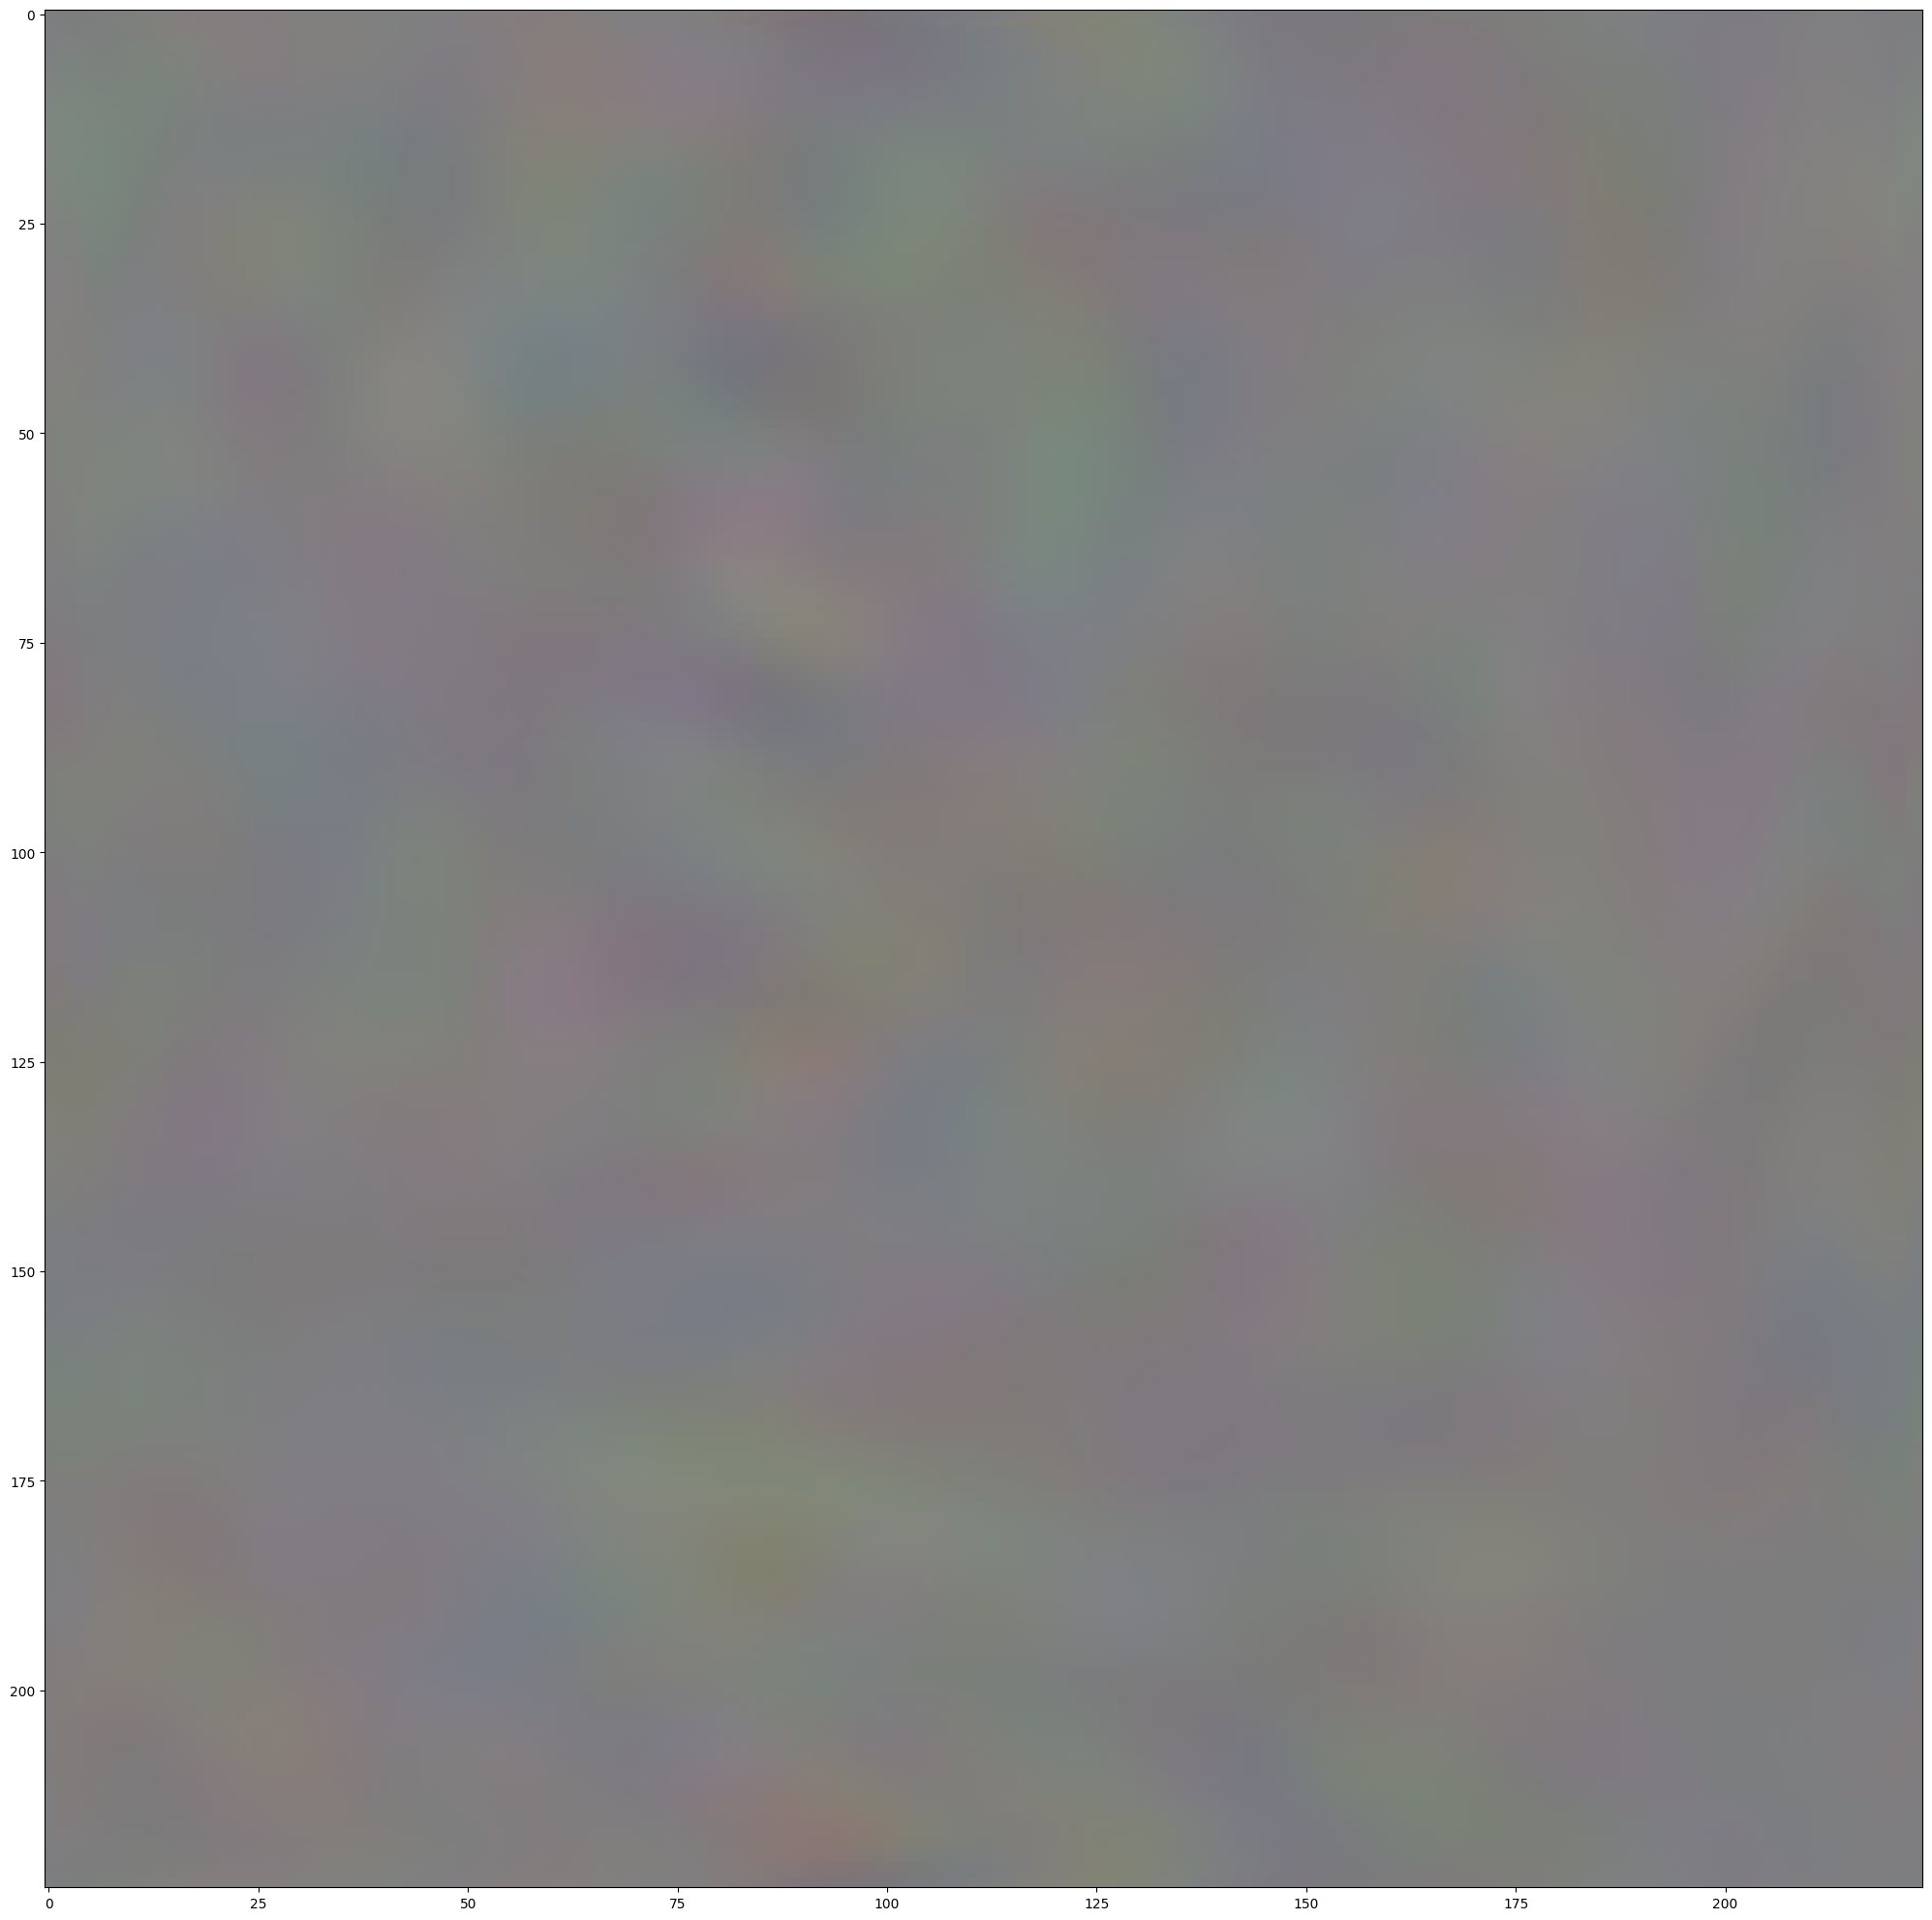

In [73]:
model = VGG16(weights=None,include_top=True)
INDEX = 20

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()